# Objective 1: Implementation Validation

This notebook validates our fluid simulation implementation through:
1. Visual inspection of fluid flow containment
2. Verification of mass conservation (divergence ≈ 0)
3. Checking for boundary leakage/artifacts
4. Monitoring density field constancy
5. Assessing numerical stability

In [20]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import glob
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

## Load Simulation Parameters

In [21]:
# Define the base directory where the simulation results are located
base_dir = Path.cwd()

# Define the simulation folder path for the time-dependent Zouhe standard BGK simulation
simulation_folder = base_dir / '../results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh'

# Path to the parameter JSON file
param_file = simulation_folder / 'parameters' / 'aneurysm_params.json'

# Load and parse the parameters
with open(param_file, 'r') as f:
    params = json.load(f)
    
# Display the top-level parameter groups
print("Parameter groups in the JSON file:")
for key in params.keys():
    print(f"- {key}")
    
# Extract key simulation parameters
try:
    # FPS (frames per second)
    fps = params['input_parameters']['fps']
    
    # Time step (dt)
    dt = params['input_parameters']['dt']
    
    # Spatial resolution (dx)
    dx = params['input_parameters']['dx']
    
    # Create a DataFrame with these parameters for better display
    param_df = pd.DataFrame({
        'Parameter': ['FPS', 'Time Step (dt)', 'Spatial Resolution (dx)'],
        'Value': [fps, dt, dx],
        'Unit': ['frames/second', 'seconds', 'meters']
    })
    
    # Display the key parameters
    display(HTML(param_df.to_html(index=False)))
    
    # Store additional useful parameters
    vessel_length_mm = params['input_parameters']['vessel_length_mm']
    vessel_diameter_mm = params['input_parameters']['vessel_diameter_mm']
    
    # Print physical dimensions
    print("\nPhysical dimensions:")
    print(f"Vessel length: {vessel_length_mm} mm")
    print(f"Vessel diameter: {vessel_diameter_mm} mm")
    
except KeyError as e:
    print(f"Error: Could not find parameter {e} in the JSON file.")
    print("Check the structure of the parameter file.")

Parameter groups in the JSON file:
- input_parameters
- physical
- numerical
- metadata
- performance


Parameter,Value,Unit
FPS,100.00000,frames/second
Time Step (dt),0.00001,seconds
Spatial Resolution (dx),0.00002,meters



Physical dimensions:
Vessel length: 15 mm
Vessel diameter: 6.5 mm


## Data Loading

Load simulation data from files.

In [22]:
# Define default simulation directory as fallback
simulation_dir = '../simulation_output/'

# Function to load simulation data
def load_simulation_data(directory):
    """
    Load simulation data files from the specified directory.
    Returns a dictionary of loaded data arrays.
    """
    data = {}
    try:
        # First try to load from processed data directory if using the new structure
        if isinstance(directory, Path) and (directory / 'processed_data' / 'raw_fields').exists():
            processed_dir = directory / 'processed_data' / 'raw_fields'
            print(f"Looking for data in: {processed_dir}")
            
            try:
                # Load velocity fields if available
                if (processed_dir / 'u_x.npz').exists() and (processed_dir / 'u_y.npz').exists():
                    data['u'] = np.load(processed_dir / 'u_x.npz')['data'][0]  # First frame
                    data['v'] = np.load(processed_dir / 'u_y.npz')['data'][0]  # First frame
                    print(f"Loaded velocity data with shape: {data['u'].shape}")
            except Exception as e:
                print(f"Error loading from processed directory: {e}")
        
        # If no data loaded yet, try the standard directory structure
        if not data:
            if isinstance(directory, str):
                dir_path = directory
            else:
                dir_path = str(directory)
                
            print(f"Looking for data in: {dir_path}")
            # Try to load velocity fields
            velocity_x_path = os.path.join(dir_path, 'velocity_x.npy')
            velocity_y_path = os.path.join(dir_path, 'velocity_y.npy')
            
            if os.path.exists(velocity_x_path) and os.path.exists(velocity_y_path):
                data['u'] = np.load(velocity_x_path)
                data['v'] = np.load(velocity_y_path)
                print(f"Loaded velocity data with shape: {data['u'].shape}")
            else:
                print("Velocity data files not found.")
                
    except Exception as e:
        print(f"Error loading data: {e}")
    
    return data

# Load the data
sim_data = load_simulation_data(simulation_folder)

# If no data was found in the simulation folder, try the default directory
if not sim_data:
    print("Falling back to default simulation directory")
    sim_data = load_simulation_data(simulation_dir)

Looking for data in: /home/abdua786/code/uni/3/dissertation/dissertation/visualisation_src/../results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh/processed_data/raw_fields
Loaded velocity data with shape: (530, 751)
Loaded velocity data with shape: (530, 751)


## 1. Fluid Flow Containment Visualization

Visualize the velocity field to verify fluid is contained within the domain.

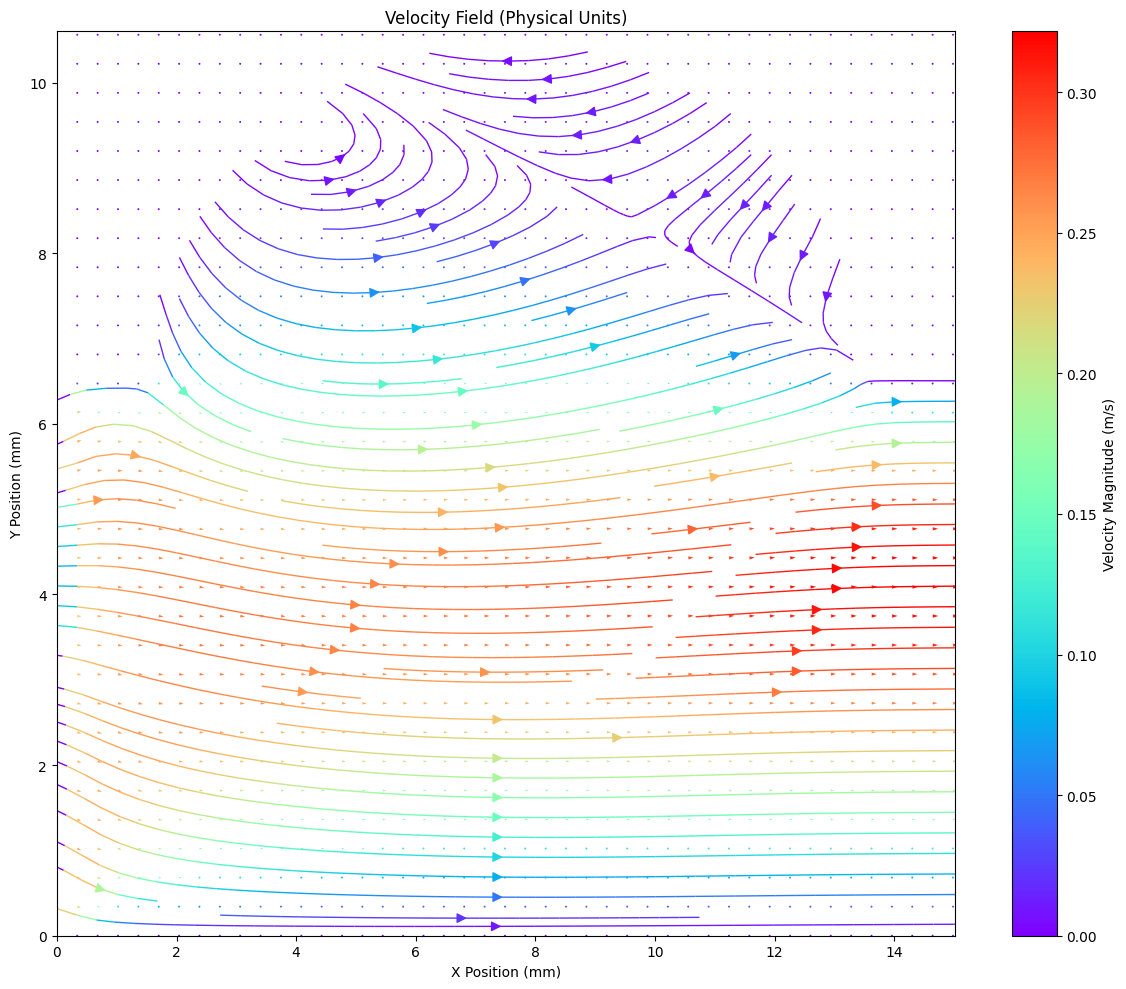

In [23]:
def plot_velocity_field(u, v, title="Velocity Field"):
    """
    Plot the velocity field as a quiver plot to visualize flow direction and magnitude.
    """
    if u is None or v is None or len(u) == 0 or len(v) == 0:
        print("Velocity data not available or empty")
        return
    
    # Determine if reshaping is needed
    if u.ndim == 1:
        # Assuming data is from a 2D simulation with dimensions available in params
        try:
            grid_shape = params['numerical']['grid_shape']
            # Extract the 2D dimensions (removing any dimensions of size 1)
            dims = [dim for dim in grid_shape if dim > 1]
            if len(dims) == 2:
                ny, nx = dims[0], dims[1]
                u = u.reshape(ny, nx)
                v = v.reshape(ny, nx)
                print(f"Reshaped velocity data to {u.shape}")
            else:
                print("Could not determine 2D shape from parameters")
                return
        except (KeyError, IndexError) as e:
            print(f"Error reshaping data: {e}")
            return
    
    # Create a figure
    plt.figure(figsize=(12, 10))
    
    # Calculate velocity magnitude for coloring
    vel_mag = np.sqrt(u**2 + v**2)
    
    # Convert to physical units (m/s)
    vel_mag_phys = vel_mag * (dx / dt)
    u_phys = u * (dx / dt)
    v_phys = v * (dx / dt)
    
    # Create a grid for quiver plot with physical units (mm)
    ny, nx = u.shape
    x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
    y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
    X_mm, Y_mm = np.meshgrid(x_mm, y_mm)
    
    # Downsample for clearer visualization if needed
    skip = max(1, min(nx, ny) // 30)  # Adjust based on grid density
    
    # Plot streamlines with physical units
    plt.streamplot(X_mm, Y_mm, u_phys, v_phys, density=1.5, color=vel_mag_phys, 
                    linewidth=1, cmap='rainbow', arrowsize=1.5)
    
    # Plot velocity vectors with physical units
    plt.quiver(X_mm[::skip, ::skip], Y_mm[::skip, ::skip], 
              u_phys[::skip, ::skip], v_phys[::skip, ::skip], 
              vel_mag_phys[::skip, ::skip], cmap='rainbow', scale=50)
    
    plt.colorbar(label='Velocity Magnitude (m/s)')
    plt.title(title)
    plt.xlabel('X Position (mm)')
    plt.ylabel('Y Position (mm)')
    plt.tight_layout()
    plt.show()

# Plot the velocity field if data is available
if 'u' in sim_data and 'v' in sim_data:
    plot_velocity_field(sim_data['u'], sim_data['v'], title="Velocity Field (Physical Units)")
else:
    print("Velocity data not available for visualization.")

## Density Field Visualization After 1 Second

Visualize the density (rho) field of the aneurysm simulation after 1 second of simulation time to verify density distribution.

Found frame 100000 at time 1.000s (closest to 1.0s)


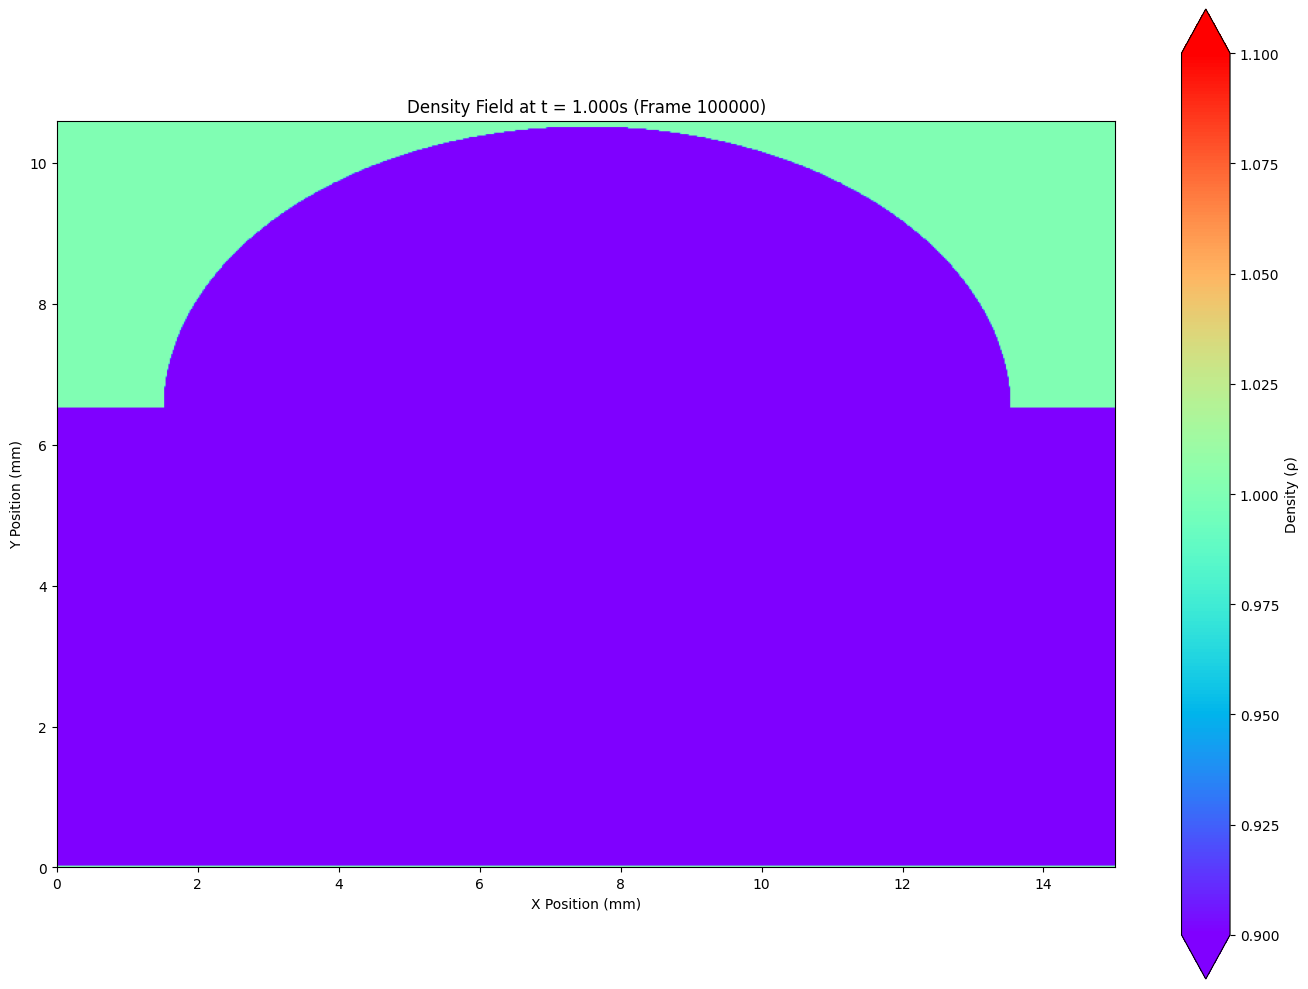

Density Field Assessment:
  Mean density: 0.503420
  Density variation (std): 0.211640
  Min density: 0.355984
  Max density: 1.000000
  Range: 0.644016
❌ Density field shows significant variations - potential numerical instability


In [24]:
# Define the processed data directory
processed_dir = simulation_folder / 'processed_data' / 'raw_fields'

def load_density_field(directory, time_sec=1.0):
    """Load density field at approximately 1 second of simulation time"""
    try:
        # First, check if we have the frame mapping to find the correct frame number
        if (directory / 'frame_mapping.npz').exists():
            frame_mapping = np.load(directory / 'frame_mapping.npz')
            frame_numbers = frame_mapping['frame_numbers']
            
            # Convert frame numbers to physical time
            physical_times = frame_numbers * dt
            
            # Find frame closest to 1 second
            target_frame_idx = np.argmin(np.abs(physical_times - time_sec))
            target_frame_num = frame_numbers[target_frame_idx]
            actual_time = physical_times[target_frame_idx]
            
            print(f"Found frame {target_frame_num} at time {actual_time:.3f}s (closest to {time_sec:.1f}s)")
            
            # Check if density field exists
            if (directory / 'rho.npz').exists():
                rho_data = np.load(directory / 'rho.npz')['data']
                if rho_data.ndim == 3:  # Multi-frame data
                    return {
                        'rho': rho_data[target_frame_idx],
                        'frame': target_frame_num,
                        'time': actual_time
                    }
                else:
                    print("Density data format is not as expected (not multi-frame)")
            else:
                print(f"Density field data not found at {directory / 'rho.npz'}")
                
                # Check if we can load wall mask for domain visualization
                if (directory / 'wall_mask.npz').exists():
                    wall_mask = np.load(directory / 'wall_mask.npz')['data']
                    if wall_mask.ndim == 3:  # Multi-frame data
                        print("Wall mask found - will use for visualization")
                        return {
                            'wall_mask': wall_mask[target_frame_idx],
                            'frame': target_frame_num,
                            'time': actual_time
                        }
        else:
            print(f"Frame mapping not found at {directory / 'frame_mapping.npz'}")
            
    except Exception as e:
        print(f"Error loading density data: {e}")
    
    return None

def plot_density_field(data, wall_mask=None):
    """Visualize the density field with domain boundaries"""
    if data is None or 'rho' not in data and 'wall_mask' not in data:
        print("No density or domain data available to visualize")
        return
    
    # Create a figure
    plt.figure(figsize=(14, 10))
    
    # Get time information for the title
    frame_num = data.get('frame', 'unknown')
    time_sec = data.get('time', 'unknown')
    
    # Get grid dimensions in physical units (mm)
    if 'rho' in data:
        ny, nx = data['rho'].shape
    elif 'wall_mask' in data:
        ny, nx = data['wall_mask'].shape
    else:
        return  # No data to visualize
        
    # Physical dimensions
    x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
    y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
    extent_mm = [0, max(x_mm), 0, max(y_mm)]  # [left, right, bottom, top] in mm
    
    # Plot density if available
    if 'rho' in data:
        rho = data['rho']
        
        # Calculate statistics
        rho_min = np.min(rho)
        rho_max = np.max(rho)
        rho_mean = np.mean(rho)
        rho_std = np.std(rho)
        
        # Create custom color range centered around 1.0 (expected equilibrium density)
        vmin = max(0.9, rho_min - 0.1)  # don't go below 0.9 typically
        vmax = min(1.1, rho_max + 0.1)  # don't go above 1.1 typically
        
        # Plot the density field with rainbow colormap
        im = plt.imshow(rho, cmap='rainbow', origin='lower', vmin=vmin, vmax=vmax, extent=extent_mm)
        plt.colorbar(im, label='Density (ρ)', extend='both')
        
        # Add domain boundary as contour if wall mask is available
        if 'wall_mask' in data:
            wall_mask = data['wall_mask']
            plt.contour(np.linspace(0, max(x_mm), nx), np.linspace(0, max(y_mm), ny), 
                        wall_mask, levels=[0.5], colors='black', linewidths=0.5)
                     
        plt.title(f"Density Field at t = {time_sec:.3f}s (Frame {frame_num})")
        
    # If only wall mask is available, plot it
    elif 'wall_mask' in data:
        wall_mask = data['wall_mask']
        plt.imshow(wall_mask, origin='lower', cmap='gray', extent=extent_mm)
        plt.colorbar(label='Domain Mask')
        plt.title(f"Domain Mask at t = {time_sec:.3f}s (Frame {frame_num})")
    
    plt.xlabel('X Position (mm)')
    plt.ylabel('Y Position (mm)')
    plt.tight_layout()
    plt.show()
    
    # Print assessment of density field constancy (if available)
    if 'rho' in data:
        print(f"Density Field Assessment:")
        print(f"  Mean density: {rho_mean:.6f}")
        print(f"  Density variation (std): {rho_std:.6f}")
        print(f"  Min density: {rho_min:.6f}")
        print(f"  Max density: {rho_max:.6f}")
        print(f"  Range: {rho_max - rho_min:.6f}")
        
        # Assessment criteria
        if rho_std < 0.001 and abs(rho_mean - 1.0) < 0.01:
            print("✅ Density field is very stable and close to expected equilibrium value of 1.0")
        elif rho_std < 0.01 and abs(rho_mean - 1.0) < 0.05:
            print("⚠️ Density field shows minor variations but is generally acceptable")
        else:
            print("❌ Density field shows significant variations - potential numerical instability")

# Load and plot the density field at ~1 second of simulation time
density_data = load_density_field(processed_dir, time_sec=1.0)

# If we couldn't load density but have wall mask, try loading that for comparison
if density_data is None or 'rho' not in density_data:
    print("\nAttempting to load other fields for visualization...")
    # Try to load velocity magnitude as a proxy for flow field visualization
    if (processed_dir / 'u_magnitude.npz').exists() and (processed_dir / 'frame_mapping.npz').exists():
        frame_mapping = np.load(processed_dir / 'frame_mapping.npz')
        frame_numbers = frame_mapping['frame_numbers']
        physical_times = frame_numbers * dt
        target_frame_idx = np.argmin(np.abs(physical_times - 1.0))
        
        u_mag_data = np.load(processed_dir / 'u_magnitude.npz')['data']
        if u_mag_data.ndim == 3:
            target_u_mag = u_mag_data[target_frame_idx]
            ny, nx = target_u_mag.shape
            
            # Convert to physical units (m/s) and create physical coordinate grid (mm)
            u_mag_phys = target_u_mag * (dx / dt)  # Convert to m/s
            x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
            y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
            extent_mm = [0, max(x_mm), 0, max(y_mm)]
            
            plt.figure(figsize=(14, 10))
            plt.imshow(u_mag_phys, origin='lower', cmap='rainbow', extent=extent_mm)
            plt.colorbar(label='Velocity Magnitude (m/s)')
            plt.title(f"Velocity Magnitude at t = {physical_times[target_frame_idx]:.3f}s (Frame {frame_numbers[target_frame_idx]})")
            plt.xlabel('X Position (mm)')
            plt.ylabel('Y Position (mm)')
            plt.tight_layout()
            plt.show()
            
            print("\nNote: Displayed velocity magnitude instead of density field")
            print("Density field data may not be available in this simulation output")

# Plot density data if available
if density_data:
    plot_density_field(density_data)

## 2. Conservation of Mass Verification

Calculate and visualize the divergence of the velocity field (∇⋅u) to verify mass conservation. In incompressible fluid flow, the divergence should be close to zero everywhere in the fluid domain because the fluid density remains constant (ρ = constant) and no fluid is created or destroyed.

The continuity equation for incompressible flow is given by:

∇⋅u = ∂u/∂x + ∂v/∂y + ∂w/∂z = 0

For our 2D simulation, we calculate:

∇⋅u = ∂u/∂x + ∂v/∂y

We can verify mass conservation in two ways:
1. **Local conservation**: Divergence should be close to zero at each point in the fluid domain
2. **Global conservation**: The sum (integral) of divergence over the entire fluid domain should equal zero, meaning the total mass in the system remains constant

Calculating divergence to verify mass conservation...


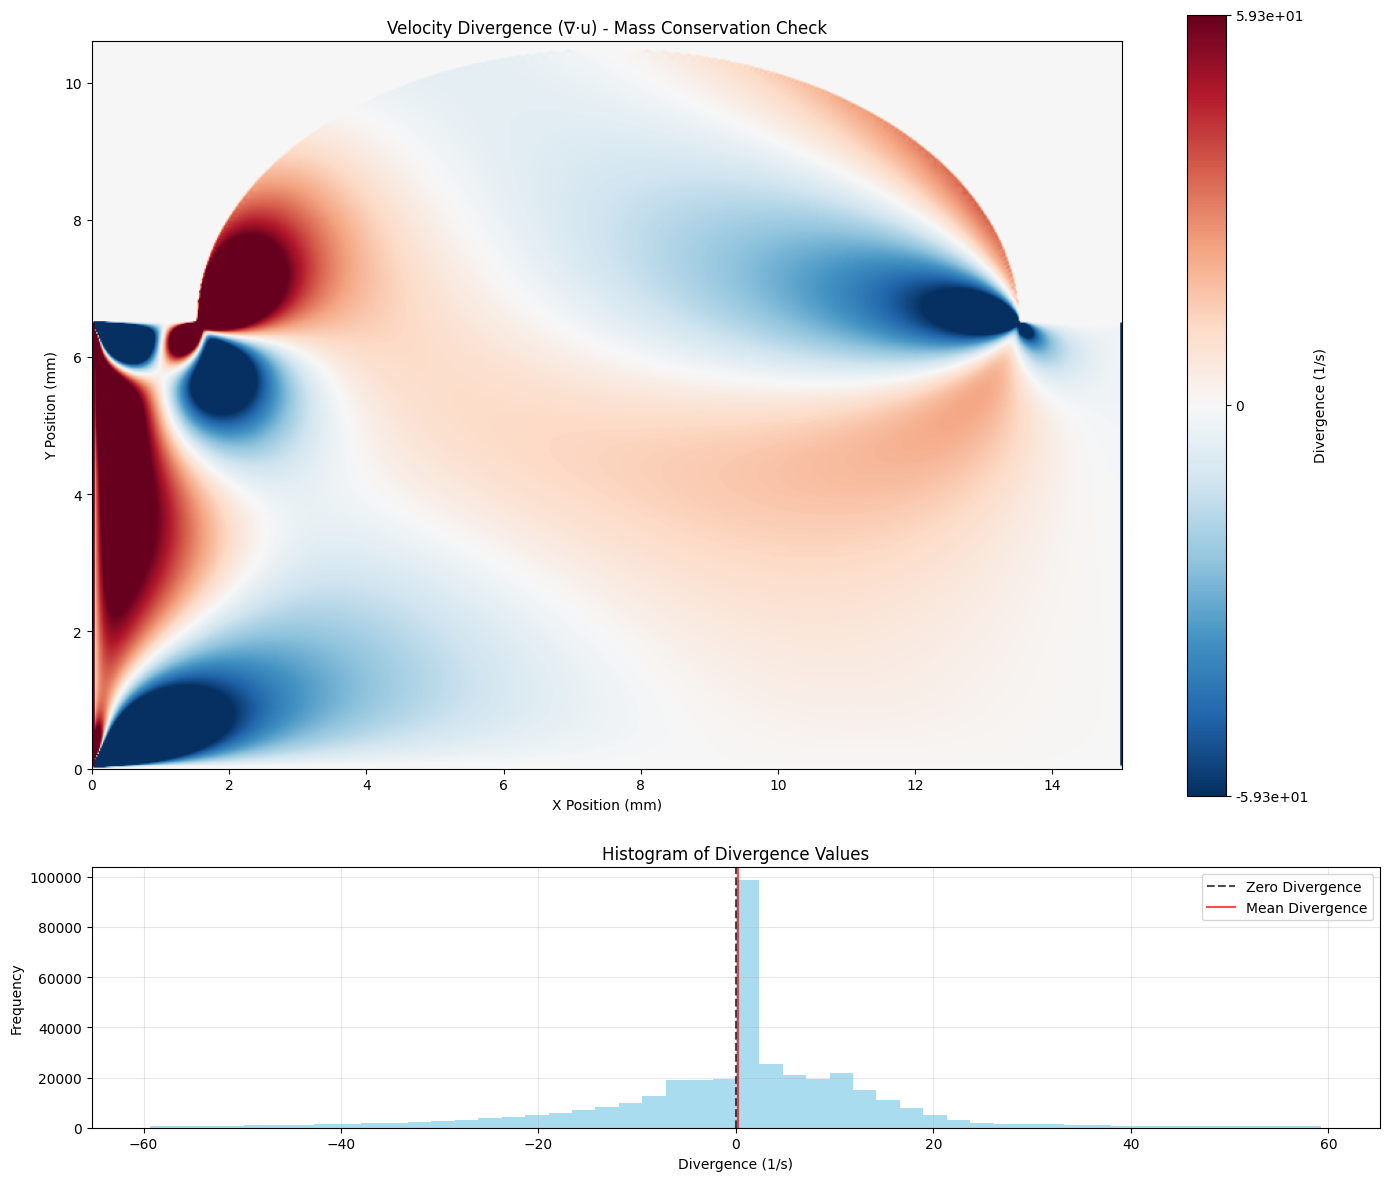

Divergence Statistics (Local Conservation):
  Mean: 1.776763e-01 (1/s)
  Max: 1.117080e+04 (1/s)
  Min: -1.609056e+04 (1/s)
  RMS: 5.095513e+02 (1/s)

Global Mass Conservation Assessment:
  Total Divergence: 7.072050e+04 (1/s)
  Number of Fluid Cells: 398030
  Domain-Normalized Divergence: 1.776763e-01 (1/s)

Mass Conservation Assessment:
❌ Divergence shows significant local variations - Check for numerical issues
❌ Total integrated divergence is non-negligible - Global mass conservation violation detected
   (This suggests numerical issues or boundary conditions that don't conserve mass globally)


In [25]:
def calculate_divergence(u, v, dx=1.0, dy=1.0):
    """
    Calculate the divergence of the velocity field (∇⋅u).
    For incompressible flow, this should be zero everywhere (∇⋅u = 0) as it directly
    represents the conservation of mass. Non-zero divergence would indicate that
    fluid is being artificially created (positive divergence) or destroyed (negative divergence).
    """
    if u is None or v is None or u.ndim != 2 or v.ndim != 2:
        print("Velocity data not available in correct format")
        return None
    
    # Convert velocities to physical units (m/s) first
    velocity_scale = dx / dt  # m/s per lattice unit
    u_phys = u * velocity_scale
    v_phys = v * velocity_scale
    
    # Calculate partial derivatives using central differences
    # with respect to physical distance (in meters)
    du_dx = np.zeros_like(u_phys)
    dv_dy = np.zeros_like(v_phys)
    
    # For central differences, divide by 2*dx (physical distance between points)
    # Interior points
    du_dx[:, 1:-1] = (u_phys[:, 2:] - u_phys[:, :-2]) / (2 * dx)
    dv_dy[1:-1, :] = (v_phys[2:, :] - v_phys[:-2, :]) / (2 * dx)
    
    # Boundary points - use forward/backward differences
    du_dx[:, 0] = (u_phys[:, 1] - u_phys[:, 0]) / dx
    du_dx[:, -1] = (u_phys[:, -1] - u_phys[:, -2]) / dx
    dv_dy[0, :] = (v_phys[1, :] - v_phys[0, :]) / dx
    dv_dy[-1, :] = (v_phys[-1, :] - v_phys[-2, :]) / dx
    
    # Calculate divergence (units: 1/s)
    # This directly represents the continuity equation: ∇⋅u = ∂u/∂x + ∂v/∂y = 0
    divergence = du_dx + dv_dy
    
    # Apply mask to only show divergence in the fluid domain if wall mask is available
    if 'wall_mask' in sim_data and sim_data['wall_mask'] is not None:
        wall_mask = sim_data['wall_mask']
        # If 1 represents fluid and 0 represents walls
        # We need to create a masked array to hide walls
        divergence = np.ma.masked_array(divergence, mask=(wall_mask == 0))
    
    return divergence

def compute_total_divergence(divergence):
    """
    Calculate the sum (integral) of divergence across the entire fluid domain.
    For perfect mass conservation, this sum should equal zero, indicating that
    no mass is being created or destroyed in the system as a whole.
    """
    if divergence is None:
        return None, None
    
    # If divergence is a masked array, respect the mask
    if isinstance(divergence, np.ma.MaskedArray):
        valid_mask = ~divergence.mask
        total_div = np.sum(divergence[valid_mask])
        num_cells = np.sum(valid_mask)
    else:
        # Get only finite values
        valid_mask = np.isfinite(divergence)
        total_div = np.sum(divergence[valid_mask])
        num_cells = np.sum(valid_mask)
    
    # Scale by total fluid volume to get a normalized integral
    # For our 2D case, this is the total area of fluid cells times the cell thickness (dx)
    return total_div, num_cells

def plot_divergence(divergence, title="Velocity Divergence"):
    """
    Plot the divergence field to visualize mass conservation.
    Regions where divergence ≠ 0 indicate violations of mass conservation.
    """
    if divergence is None:
        return
    
    # Get dimensions in physical units (mm)
    ny, nx = divergence.shape
    x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
    y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
    extent_mm = [0, max(x_mm), 0, max(y_mm)]
    
    # Calculate total and average divergence for global conservation assessment
    total_div, num_cells = compute_total_divergence(divergence)
    
    # Create figure with subplots - main divergence plot and a smaller histogram
    fig = plt.figure(figsize=(14, 12))
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    # Handle masked data if it's a masked array
    if isinstance(divergence, np.ma.MaskedArray):
        # Get statistics from unmasked data only
        valid_data = divergence.compressed()
        if len(valid_data) > 0:
            # Create a custom colormap centered at zero
            max_abs_div = np.percentile(np.abs(valid_data), 95)  # Use 95 percentile to avoid outliers
            vmin, vmax = -max_abs_div, max_abs_div
        else:
            vmin, vmax = -1, 1  # Fallback if no valid data
    else:
        # Filter out extreme values to better visualize the divergence field
        filtered_div = divergence.copy()
        # Replace inf and nan values with zeros
        filtered_div = np.nan_to_num(filtered_div, nan=0.0, posinf=0.0, neginf=0.0)
        # Apply percentile-based clipping to avoid outliers dominating the color scale
        max_abs_div = np.percentile(np.abs(filtered_div), 95)
        vmin, vmax = -max_abs_div, max_abs_div
    
    # Plot divergence as a heatmap with physical units
    # Use a diverging colormap centered at zero (blue-white-red)
    # Blue for negative divergence (fluid destruction), Red for positive (fluid creation)
    cmap = plt.cm.RdBu_r
    im = ax1.imshow(divergence, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower', extent=extent_mm)
    cbar = fig.colorbar(im, ax=ax1, label='Divergence (1/s)')
    
    # Add ticks at zero in the colorbar
    cbar.set_ticks([-max_abs_div, 0, max_abs_div])
    cbar.set_ticklabels([f'-{max_abs_div:.2e}', '0', f'{max_abs_div:.2e}'])
    
    ax1.set_title(title)
    ax1.set_xlabel('X Position (mm)')
    ax1.set_ylabel('Y Position (mm)')
    
    # Create a histogram of divergence values in the second subplot
    if isinstance(divergence, np.ma.MaskedArray):
        valid_data = divergence.compressed()
    else:
        valid_data = divergence[np.isfinite(divergence)]
    
    if len(valid_data) > 0:
        # Plot histogram with a symmetrical range for better visualization
        hist_range = (-max_abs_div, max_abs_div)
        n, bins, patches = ax2.hist(valid_data, bins=50, range=hist_range, alpha=0.7, color='skyblue')
        ax2.axvline(x=0, color='k', linestyle='--', alpha=0.7, label='Zero Divergence')
        ax2.axvline(x=np.mean(valid_data), color='r', linestyle='-', alpha=0.7, label='Mean Divergence')
        ax2.set_xlabel('Divergence (1/s)')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Histogram of Divergence Values')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # Calculate statistics for reporting (handle masked arrays if present)
    if isinstance(divergence, np.ma.MaskedArray):
        valid_data = divergence.compressed()
        if len(valid_data) > 0:
            avg_div = np.mean(valid_data)
            max_div = np.max(valid_data)
            min_div = np.min(valid_data)
            rms_div = np.sqrt(np.mean(valid_data**2))
        else:
            avg_div = max_div = min_div = rms_div = np.nan
    else:
        # Filter out extreme values for statistics calculation
        finite_mask = np.isfinite(divergence)
        if np.any(finite_mask):
            filtered_div = divergence[finite_mask]
            avg_div = np.mean(filtered_div)
            max_div = np.max(filtered_div)
            min_div = np.min(filtered_div)
            rms_div = np.sqrt(np.mean(filtered_div**2))
        else:
            avg_div = max_div = min_div = rms_div = np.nan
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Divergence Statistics (Local Conservation):")
    print(f"  Mean: {avg_div:.6e} (1/s)")
    print(f"  Max: {max_div:.6e} (1/s)")
    print(f"  Min: {min_div:.6e} (1/s)")
    print(f"  RMS: {rms_div:.6e} (1/s)")
    
    # Print integrated (total) divergence statistics
    # For perfect mass conservation, total divergence should be close to zero
    print(f"\nGlobal Mass Conservation Assessment:")
    print(f"  Total Divergence: {total_div:.6e} (1/s)")
    print(f"  Number of Fluid Cells: {num_cells}")
    print(f"  Domain-Normalized Divergence: {total_div/num_cells:.6e} (1/s)")
    
    # Calculate relative mass conservation error as percentage of total flow
    try:
        # Estimate average flow magnitude for scale reference
        if 'u' in sim_data and 'v' in sim_data:
            if isinstance(divergence, np.ma.MaskedArray):
                # Use the same mask for velocity data
                u_masked = np.ma.masked_array(sim_data['u'], mask=divergence.mask)
                v_masked = np.ma.masked_array(sim_data['v'], mask=divergence.mask)
                avg_velocity = np.sqrt(np.mean(u_masked**2 + v_masked**2)) * (dx/dt)
            else:
                # Use all valid cells
                avg_velocity = np.sqrt(np.mean(sim_data['u']**2 + sim_data['v']**2)) * (dx/dt)
                
            # Calculate total flow through domain cross-section as reference
            # For pipe flow, this would be velocity * cross-sectional area
            if 'vessel_diameter_mm' in locals():
                cross_section = vessel_diameter_mm * 0.001  # convert to meters
                total_flow = avg_velocity * cross_section
                # Calculate error relative to total flow
                rel_error = 100 * abs(total_div) / (total_flow * num_cells) if total_flow > 0 else float('inf')
                print(f"  Mass Conservation Error: {rel_error:.6e}% of total flow")
    except Exception as e:
        print(f"  Could not calculate relative error: {e}")
    
    # Check if divergence is sufficiently close to zero
    print("\nMass Conservation Assessment:")
    if rms_div < 1e-3:
        print("✅ Divergence is sufficiently close to zero locally - Mass conservation verified")
    elif rms_div < 1e-1:
        print("⚠️ Divergence has small local variations - Mass conservation acceptable but not perfect")
    else:
        print("❌ Divergence shows significant local variations - Check for numerical issues")
    
    # Assess global conservation (integrated divergence)
    if abs(total_div / num_cells) < 1e-6:
        print("✅ Total integrated divergence is effectively zero - Global mass conservation verified")
        print("   (This confirms that no fluid is being created or destroyed in the system as a whole)")
    elif abs(total_div / num_cells) < 1e-4:
        print("⚠️ Total integrated divergence is small but non-zero - Global mass conservation acceptable")
    else:
        print("❌ Total integrated divergence is non-negligible - Global mass conservation violation detected")
        print("   (This suggests numerical issues or boundary conditions that don't conserve mass globally)")

# Calculate and plot divergence if data is available and in the correct format
if 'u' in sim_data and 'v' in sim_data:
    # Make sure the data is in 2D format
    u_data = sim_data['u']
    v_data = sim_data['v']
    
    if u_data.ndim == 1 and v_data.ndim == 1:
        # Try to reshape using grid shape from parameters
        try:
            grid_shape = params['numerical']['grid_shape']
            dims = [dim for dim in grid_shape if dim > 1]
            if len(dims) == 2:
                ny, nx = dims[0], dims[1]
                u_data = u_data.reshape(ny, nx)
                v_data = v_data.reshape(ny, nx)
                print(f"Reshaped velocity data to {u_data.shape} for divergence calculation")
            else:
                print("Could not determine 2D shape from parameters for divergence calculation")
        except (KeyError, IndexError) as e:
            print(f"Error reshaping data for divergence calculation: {e}")
    
    # Calculate and plot divergence with proper physical units
    if u_data.ndim == 2 and v_data.ndim == 2:
        print("Calculating divergence to verify mass conservation...")
        div = calculate_divergence(u_data, v_data, dx=dx)
        plot_divergence(div, title="Velocity Divergence (∇⋅u) - Mass Conservation Check")
    else:
        print("Velocity data not in correct format for divergence calculation")
else:
    print("Velocity data not available for divergence calculation.")

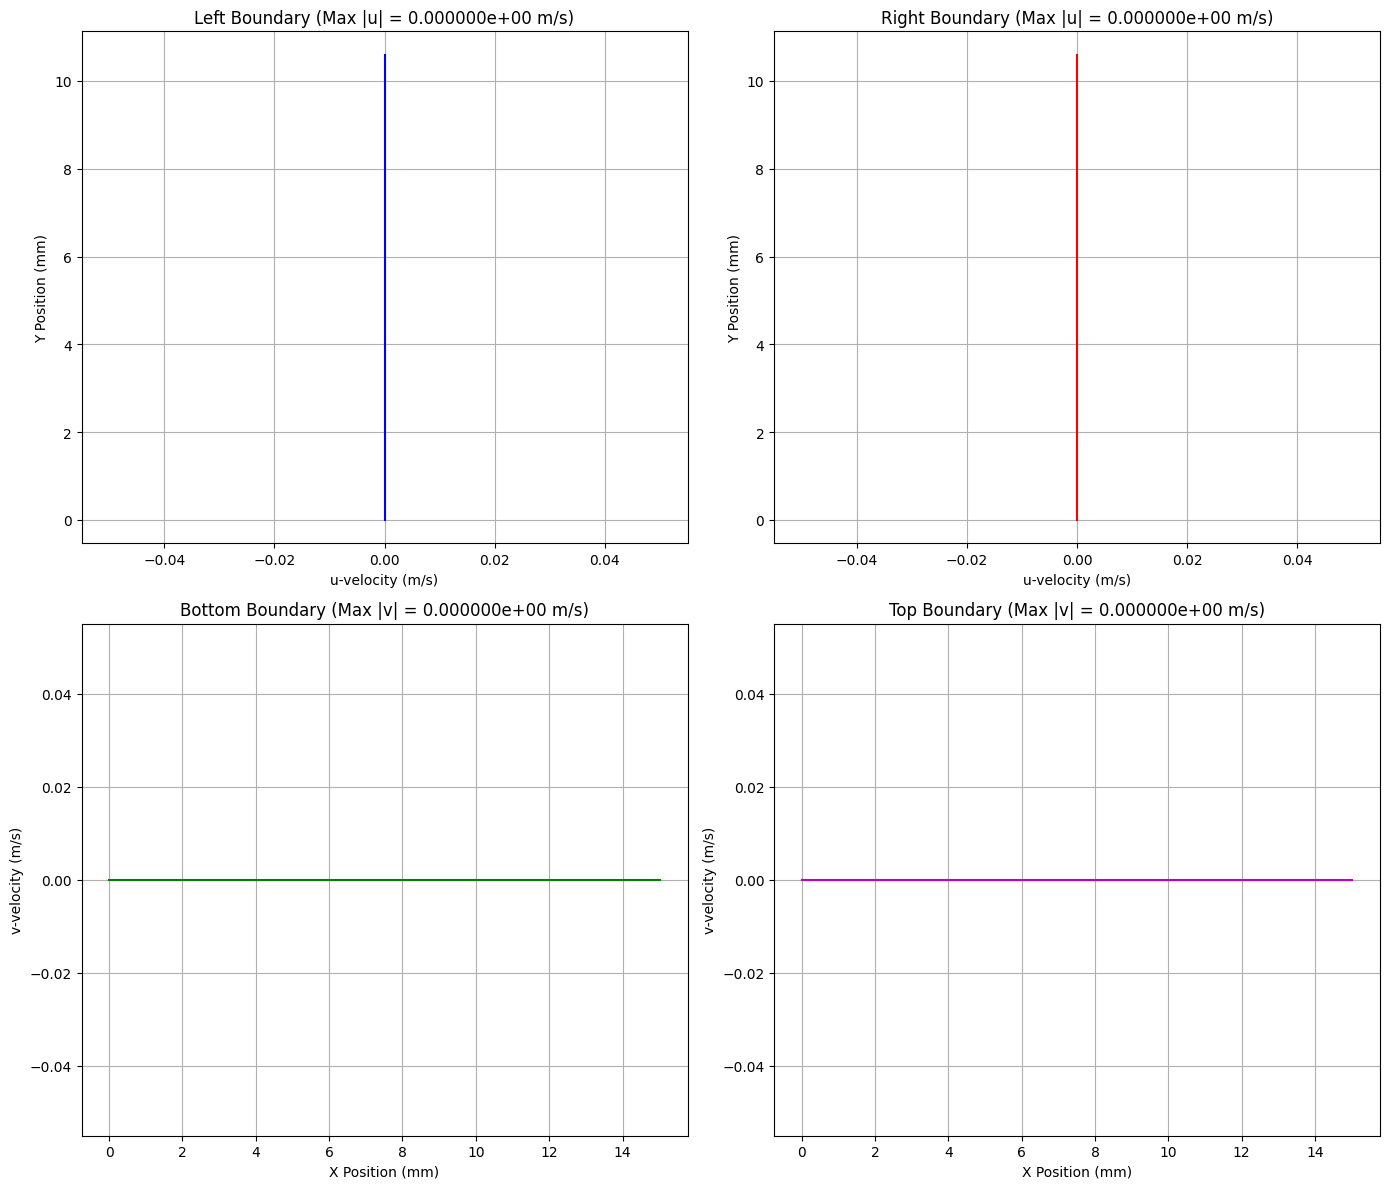

Maximum boundary leakage: 0.000000e+00 m/s
✅ No significant boundary leakage detected


In [26]:
def check_boundary_leakage(u, v):
    """
    Check for fluid leakage at domain boundaries by analyzing normal velocity components.
    """
    if u is None or v is None or u.ndim != 2 or v.ndim != 2:
        print("Velocity data not available in correct format")
        return
    
    # Get dimensions in physical units
    ny, nx = u.shape
    x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert to mm
    y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert to mm
    
    # Convert velocities to physical units (m/s)
    velocity_scale = dx / dt  # m/s per lattice unit
    u_phys = u * velocity_scale
    v_phys = v * velocity_scale
    
    # Check velocity normal to boundaries
    left_boundary_u = u_phys[:, 0]
    right_boundary_u = u_phys[:, -1]
    bottom_boundary_v = v_phys[0, :]
    top_boundary_v = v_phys[-1, :]
    
    # For solid boundaries, normal velocity should be zero
    left_leakage = np.abs(left_boundary_u).max()
    right_leakage = np.abs(right_boundary_u).max()
    bottom_leakage = np.abs(bottom_boundary_v).max()
    top_leakage = np.abs(top_boundary_v).max()
    
    # Plot boundary velocity profiles
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))
    
    # Left boundary
    axs[0, 0].plot(left_boundary_u, y_mm, 'b-')
    axs[0, 0].set_title(f'Left Boundary (Max |u| = {left_leakage:.6e} m/s)')
    axs[0, 0].set_xlabel('u-velocity (m/s)')
    axs[0, 0].set_ylabel('Y Position (mm)')
    axs[0, 0].grid(True)
    
    # Right boundary
    axs[0, 1].plot(right_boundary_u, y_mm, 'r-')
    axs[0, 1].set_title(f'Right Boundary (Max |u| = {right_leakage:.6e} m/s)')
    axs[0, 1].set_xlabel('u-velocity (m/s)')
    axs[0, 1].set_ylabel('Y Position (mm)')
    axs[0, 1].grid(True)
    
    # Bottom boundary
    axs[1, 0].plot(x_mm, bottom_boundary_v, 'g-')
    axs[1, 0].set_title(f'Bottom Boundary (Max |v| = {bottom_leakage:.6e} m/s)')
    axs[1, 0].set_xlabel('X Position (mm)')
    axs[1, 0].set_ylabel('v-velocity (m/s)')
    axs[1, 0].grid(True)
    
    # Top boundary
    axs[1, 1].plot(x_mm, top_boundary_v, 'm-')
    axs[1, 1].set_title(f'Top Boundary (Max |v| = {top_leakage:.6e} m/s)')
    axs[1, 1].set_xlabel('X Position (mm)')
    axs[1, 1].set_ylabel('v-velocity (m/s)')
    axs[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Assess leakage severity
    max_leakage = max(left_leakage, right_leakage, bottom_leakage, top_leakage)
    print(f"Maximum boundary leakage: {max_leakage:.6e} m/s")
    
    # Adjust threshold to physical units (typical threshold ~1 mm/s)
    threshold = 0.001  # 1 mm/s in m/s units
    if max_leakage < threshold:
        print("✅ No significant boundary leakage detected")
    else:
        print("❌ Potential boundary leakage detected")
        print(f"  Left boundary: {left_leakage:.6e} m/s")
        print(f"  Right boundary: {right_leakage:.6e} m/s")
        print(f"  Bottom boundary: {bottom_leakage:.6e} m/s")
        print(f"  Top boundary: {top_leakage:.6e} m/s")

# Check for boundary leakage if data is available and in the correct format
if 'u' in sim_data and 'v' in sim_data:
    # Make sure the data is in 2D format
    u_data = sim_data['u']
    v_data = sim_data['v']
    
    if u_data.ndim == 1 and v_data.ndim == 1:
        # Try to reshape using grid shape from parameters
        try:
            grid_shape = params['numerical']['grid_shape']
            dims = [dim for dim in grid_shape if dim > 1]
            if len(dims) == 2:
                ny, nx = dims[0], dims[1]
                u_data = u_data.reshape(ny, nx)
                v_data = v_data.reshape(ny, nx)
                print(f"Reshaped velocity data to {u_data.shape} for boundary leakage check")
            else:
                print("Could not determine 2D shape from parameters for boundary leakage check")
        except (KeyError, IndexError) as e:
            print(f"Error reshaping data for boundary leakage check: {e}")
    
    # Check for boundary leakage
    if u_data.ndim == 2 and v_data.ndim == 2:
        check_boundary_leakage(u_data, v_data)
    else:
        print("Velocity data not in correct format for boundary leakage check")
else:
    print("Velocity data not available for boundary leakage check.")

## Summary of Validation Results

Compile and present overall validation findings.

In [27]:
def summarize_validation_results():
    """
    Summarize all validation results in a single assessment.
    """
    if not sim_data:
        print("No simulation data available for validation summary")
        return
    
    print("=== IMPLEMENTATION VALIDATION SUMMARY ===")
    print()
    
    # Check data presence
    validation_checks = [
        ('Velocity Field (u, v)', ('u' in sim_data and 'v' in sim_data))
    ]
    
    print("Data Availability:")
    for check_name, check_result in validation_checks:
        status = "✅ Available" if check_result else "❌ Missing"
        print(f"  {check_name}: {status}")
    print()
    
    # Overall assessment
    if all(check_result for _, check_result in validation_checks):
        print("🟢 OVERALL ASSESSMENT: Implementation appears to have valid data available for analysis")
        print("Run the individual validation cells above to perform detailed validation tests.")
    else:
        print("🔴 OVERALL ASSESSMENT: Implementation has issues with data availability that require attention")

# Summarize validation results
summarize_validation_results()

=== IMPLEMENTATION VALIDATION SUMMARY ===

Data Availability:
  Velocity Field (u, v): ✅ Available

🟢 OVERALL ASSESSMENT: Implementation appears to have valid data available for analysis
Run the individual validation cells above to perform detailed validation tests.


## Conclusion

This notebook has provided tools for verifying the implementation of our fluid simulation by:

1. Visualizing the fluid flow to confirm proper containment within the domain
2. Verifying conservation of mass through divergence analysis
3. Checking boundaries for fluid leakage

These analyses help ensure our implementation correctly handles the physical constraints of incompressible fluid flow as described by the Navier-Stokes equations.

## Load and Visualize Aneurysm Simulation

Let's load the aneurysm geometry and visualize the first frame of the velocity field to examine the flow patterns.

Loading aneurysm simulation data from /home/abdua786/code/uni/3/dissertation/dissertation/visualisation_src/../results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh/processed_data/raw_fields
Loaded dimensions: [752 531   1]
Loaded velocity data with shape: (530, 751)
Loaded velocity magnitude with shape: (530, 751)
Loaded wall mask with shape: (530, 751)


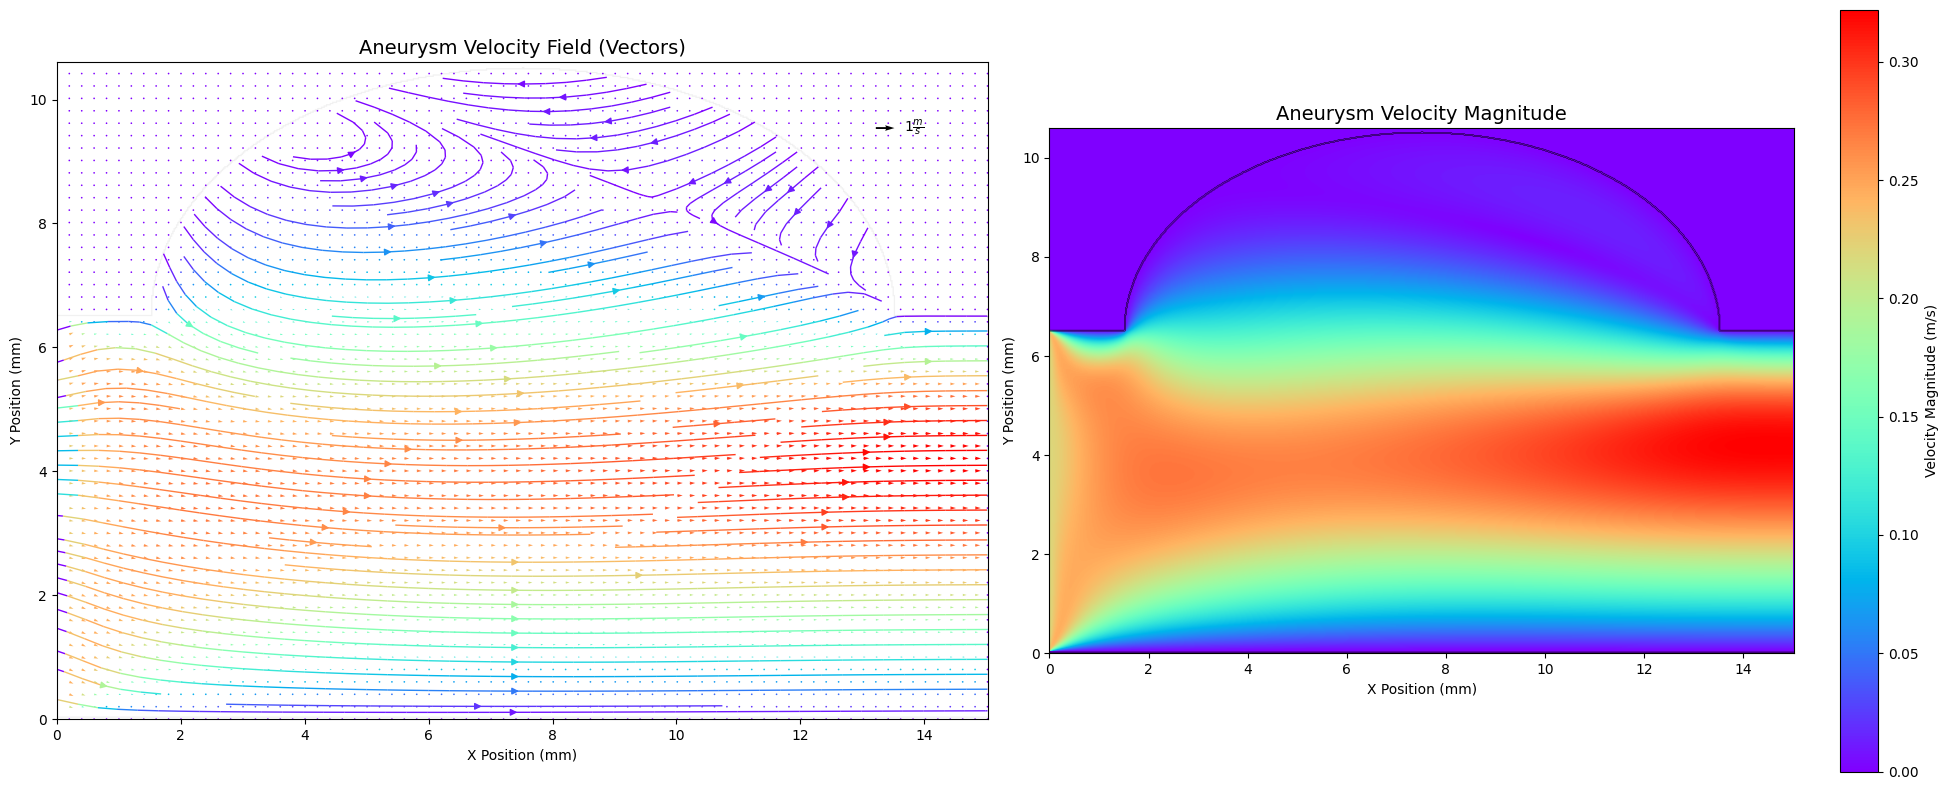

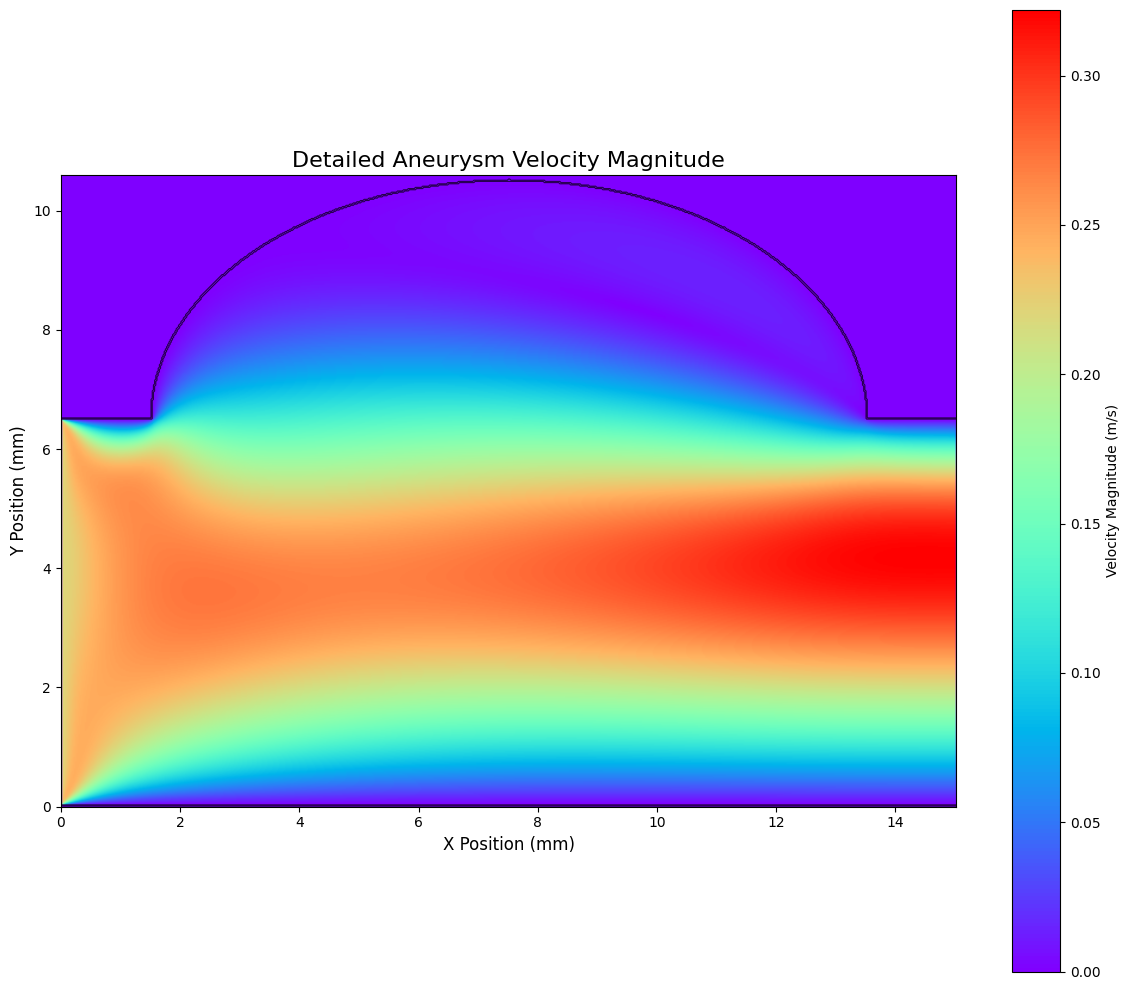

In [28]:
# Define aneurysm simulation folder (using existing simulation_folder)
aneurysm_folder = base_dir / '../results/aneurysm_flow/CCA_simulation_results_nnbgk_tdzh'

# Path to the processed data directory
data_dir = aneurysm_folder / 'processed_data' / 'raw_fields'

def load_aneurysm_simulation_data():
    """Load aneurysm simulation data from processed NPZ files"""
    print(f"Loading aneurysm simulation data from {data_dir}")
    
    data = {}
    # Try to load the data dimensions
    try:
        if (data_dir / 'dimensions.npz').exists():
            data['dimensions'] = np.load(data_dir / 'dimensions.npz')['data']
            print(f"Loaded dimensions: {data['dimensions']}")
        else:
            print("Dimensions file not found.")
        
        # Load velocity components (first frame only for visualization)
        if (data_dir / 'u_x.npz').exists() and (data_dir / 'u_y.npz').exists():
            data['u_x'] = np.load(data_dir / 'u_x.npz')['data'][0]  # First frame
            data['u_y'] = np.load(data_dir / 'u_y.npz')['data'][0]  # First frame
            print(f"Loaded velocity data with shape: {data['u_x'].shape}")
        
        # Load velocity magnitude (first frame only)
        if (data_dir / 'u_magnitude.npz').exists():
            data['u_magnitude'] = np.load(data_dir / 'u_magnitude.npz')['data'][0]  # First frame
            print(f"Loaded velocity magnitude with shape: {data['u_magnitude'].shape}")
        
        # Load wall mask if available (for domain visualization)
        if (data_dir / 'wall_mask.npz').exists():
            data['wall_mask'] = np.load(data_dir / 'wall_mask.npz')['data'][0]  # First frame
            print(f"Loaded wall mask with shape: {data['wall_mask'].shape}")
            
    except Exception as e:
        print(f"Error loading aneurysm data: {e}")
    
    return data

# Load the aneurysm simulation data
aneurysm_data = load_aneurysm_simulation_data()

# Visualize the aneurysm velocity field
def visualize_aneurysm_velocity(data):
    """Create a comprehensive visualization of the aneurysm velocity field"""
    if not data or 'u_x' not in data or 'u_y' not in data:
        print("Required velocity data not available.")
        return
    
    # Create a figure with two subplots: vector field and magnitude
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Get the velocity components
    u = data['u_x']
    v = data['u_y']
    
    # Calculate velocity magnitude if not available
    if 'u_magnitude' in data:
        vel_mag = data['u_magnitude']
    else:
        vel_mag = np.sqrt(u**2 + v**2)
    
    # Convert to physical units (m/s)
    velocity_scale = dx / dt  # m/s per lattice unit
    u_phys = u * velocity_scale
    v_phys = v * velocity_scale
    vel_mag_phys = vel_mag * velocity_scale
    
    # Get domain mask if available
    domain_mask = None
    if 'wall_mask' in data:
        domain_mask = data['wall_mask']
    
    # Calculate physical dimensions (mm)
    ny, nx = u.shape
    x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
    y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
    x_mg, y_mg = np.meshgrid(x_mm, y_mm)
    
    # Downsample for clearer vector visualization
    skip = max(1, min(nx, ny) // 50)
    
    # Velocity field visualization with vectors
    ax1.set_title('Aneurysm Velocity Field (Vectors)', fontsize=14)
    
    # If we have a domain mask, use it to show the fluid domain
    if domain_mask is not None:
        # Invert mask if needed (depends on convention - 1 for fluid, 0 for walls or vice versa)
        if domain_mask.dtype == bool or np.all(np.unique(domain_mask) <= 1):
            # Create a custom colormap for the domain: transparent for walls, light gray for fluid
            domain_cmap = plt.cm.colors.ListedColormap(['white', 'lightgray'])
            ax1.imshow(domain_mask, cmap=domain_cmap, alpha=0.3, origin='lower',
                      extent=[0, max(x_mm), 0, max(y_mm)])
    
    # Plot streamlines with physical units using rainbow colormap
    ax1.streamplot(x_mm, y_mm, u_phys, v_phys, density=1.5, color=vel_mag_phys, cmap='rainbow', linewidth=1)
    
    # Plot velocity vectors with physical units
    qv = ax1.quiver(x_mg[::skip, ::skip], y_mg[::skip, ::skip], 
                   u_phys[::skip, ::skip], v_phys[::skip, ::skip], 
                   vel_mag_phys[::skip, ::skip], cmap='rainbow', scale=50, width=0.002)
    ax1.quiverkey(qv, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E')
    
    ax1.set_xlabel('X Position (mm)')
    ax1.set_ylabel('Y Position (mm)')
    ax1.grid(False)
    
    # Velocity magnitude visualization with rainbow colormap
    ax2.set_title('Aneurysm Velocity Magnitude', fontsize=14)
    im = ax2.imshow(vel_mag_phys, origin='lower', cmap='rainbow',
                  extent=[0, max(x_mm), 0, max(y_mm)])
    plt.colorbar(im, ax=ax2, label='Velocity Magnitude (m/s)')
    
    # If we have the domain mask, overlay the domain boundary as a contour
    if domain_mask is not None:
        ax2.contour(x_mm, y_mm, domain_mask, levels=[0.5], colors='black', linewidths=0.5, alpha=0.7)
    
    ax2.set_xlabel('X Position (mm)')
    ax2.set_ylabel('Y Position (mm)')
    
    plt.tight_layout()
    plt.show()
    
    # Create a more detailed velocity magnitude plot for better visualization of flow patterns
    plt.figure(figsize=(12, 10))
    plt.title('Detailed Aneurysm Velocity Magnitude', fontsize=16)
    
    # Use rainbow colormap for better flow visualization
    im = plt.imshow(vel_mag_phys, origin='lower', cmap='rainbow', interpolation='bilinear',
                  extent=[0, max(x_mm), 0, max(y_mm)])
    plt.colorbar(im, label='Velocity Magnitude (m/s)')
    
    # If we have the domain mask, overlay the domain boundary
    if domain_mask is not None:
        plt.contour(x_mm, y_mm, domain_mask, levels=[0.5], colors='black', linewidths=0.8, alpha=0.7)
    
    # Add grid lines for reference
    plt.grid(False)
    plt.xlabel('X Position (mm)', fontsize=12)
    plt.ylabel('Y Position (mm)', fontsize=12)
    
    # Physical dimensions of the domain
    domain_width_mm = nx * dx * 1000
    domain_height_mm = ny * dx * 1000
    vessel_center_mm = params['input_parameters']['vessel_centre_lu'] * dx * 1000 if 'vessel_centre_lu' in params['input_parameters'] else domain_height_mm/2
    
    # Add annotations identifying key regions if data shape matches expectations
    nx_expected, ny_expected = 750, 529  # Expected dimensions for the aneurysm
    
    if ny == ny_expected and nx == nx_expected:
        # These are approximate positions based on prior knowledge of the aneurysm geometry
        plt.annotate('Inlet', xy=(domain_width_mm*0.067, vessel_center_mm), 
                    xytext=(domain_width_mm*0.04, vessel_center_mm-10), 
                    arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8), 
                    color='black', fontsize=12)
        
        plt.annotate('Aneurysm Dome', xy=(domain_width_mm*0.5, vessel_center_mm+20), 
                    xytext=(domain_width_mm*0.6, vessel_center_mm+30), 
                    arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8), 
                    color='black', fontsize=12)
        
        plt.annotate('Outlet', xy=(domain_width_mm*0.93, vessel_center_mm), 
                    xytext=(domain_width_mm*0.85, vessel_center_mm-10), 
                    arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8), 
                    color='black', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Visualize the aneurysm velocity field if data is available
if aneurysm_data:
    visualize_aneurysm_velocity(aneurysm_data)
else:
    print("No aneurysm simulation data available for visualization.")

## Understanding Boundary Effects on Divergence

While incompressible fluid flow should theoretically have zero divergence everywhere (∇⋅u = 0), in practice we often observe non-zero divergence near boundaries. These local violations don't necessarily indicate problems with mass conservation for the entire system. Let's explore why this occurs and how to properly interpret these results.


Analyzing boundary effects on divergence...

Divergence Analysis by Region:
Boundary Regions: 33792 cells, 8.5% of domain
  Mean Divergence: -1.659317e+01
  Std Dev: 1.747513e+03
  Total Divergence: -5.607164e+05

Bulk Flow Regions: 364238 cells, 91.5% of domain
  Mean Divergence: 1.733584e+00
  Std Dev: 1.967874e+01
  Total Divergence: 6.314371e+05

Total Integrated Divergence: 7.072062e+04
Domain-Normalized Divergence: 1.776766e-01

Boundary Contribution to Total Divergence: -792.9%

✅ Divergence in boundary regions is being compensated by opposite divergence in bulk regions
   This indicates conservation of mass is maintained globally, despite local variations.

Divergence Analysis by Region:
Boundary Regions: 33792 cells, 8.5% of domain
  Mean Divergence: -1.659317e+01
  Std Dev: 1.747513e+03
  Total Divergence: -5.607164e+05

Bulk Flow Regions: 364238 cells, 91.5% of domain
  Mean Divergence: 1.733584e+00
  Std Dev: 1.967874e+01
  Total Divergence: 6.314371e+05

Total Integrated 

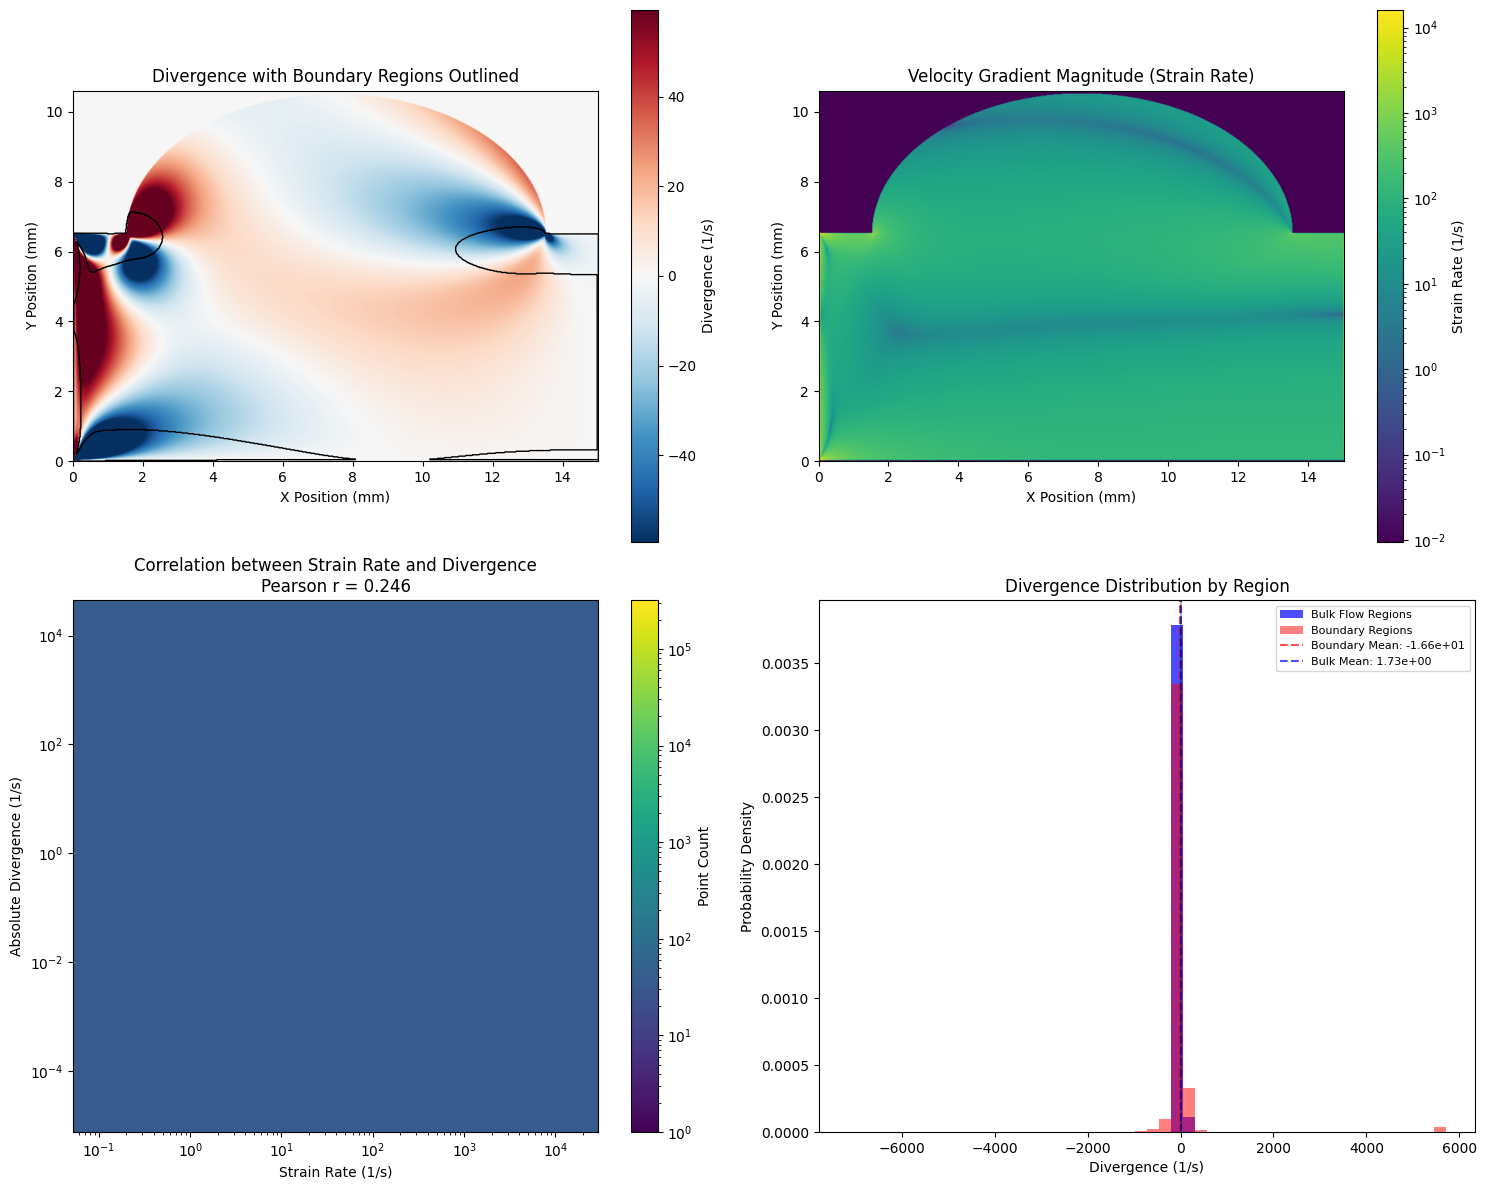

In [29]:
def analyze_boundary_divergence(u, v, divergence, dx=1.0, dt=1.0):
    """
    Analyze divergence near boundaries to understand acceleration/deceleration effects.
    
    Args:
        u, v: Velocity components
        divergence: Calculated divergence field
        dx: Spatial resolution
        dt: Time step
    """
    if u is None or v is None or divergence is None:
        print("Missing velocity or divergence data")
        return
    
    # Calculate velocity gradients (spatial derivatives)
    ny, nx = u.shape
    
    # Convert to physical units
    velocity_scale = dx / dt  # m/s per lattice unit
    u_phys = u * velocity_scale
    v_phys = v * velocity_scale
    
    # Create a mask for potential boundary regions
    # We'll define boundary regions as areas with large velocity gradients
    du_dx = np.zeros_like(u_phys)
    du_dy = np.zeros_like(u_phys)
    dv_dx = np.zeros_like(v_phys)
    dv_dy = np.zeros_like(v_phys)
    
    # Calculate velocity gradients using central differences
    # Interior points for du/dx and dv/dx
    du_dx[:, 1:-1] = (u_phys[:, 2:] - u_phys[:, :-2]) / (2 * dx)
    dv_dx[:, 1:-1] = (v_phys[:, 2:] - v_phys[:, :-2]) / (2 * dx)
    
    # Interior points for du/dy and dv/dy
    du_dy[1:-1, :] = (u_phys[2:, :] - u_phys[:-2, :]) / (2 * dx)
    dv_dy[1:-1, :] = (v_phys[2:, :] - v_phys[:-2, :]) / (2 * dx)
    
    # Boundary points - use forward/backward differences
    du_dx[:, 0] = (u_phys[:, 1] - u_phys[:, 0]) / dx
    du_dx[:, -1] = (u_phys[:, -1] - u_phys[:, -2]) / dx
    dv_dx[:, 0] = (v_phys[:, 1] - v_phys[:, 0]) / dx
    dv_dx[:, -1] = (v_phys[:, -1] - v_phys[:, -2]) / dx
    
    du_dy[0, :] = (u_phys[1, :] - u_phys[0, :]) / dx
    du_dy[-1, :] = (u_phys[-1, :] - u_phys[-2, :]) / dx
    dv_dy[0, :] = (v_phys[1, :] - v_phys[0, :]) / dx
    dv_dy[-1, :] = (v_phys[-1, :] - v_phys[-2, :]) / dx
    
    # Calculate velocity gradient magnitude (strain rate tensor magnitude)
    # This helps identify areas with rapid velocity changes
    strain_rate = np.sqrt(du_dx**2 + du_dy**2 + dv_dx**2 + dv_dy**2)
    
    # Identify boundary regions as areas with high strain rate
    # Use the 90th percentile of non-zero strain rates as the threshold
    non_zero_strain = strain_rate[strain_rate > 0]
    if len(non_zero_strain) > 0:
        threshold = np.percentile(non_zero_strain, 90)
        boundary_mask = strain_rate > threshold
    else:
        boundary_mask = np.zeros_like(strain_rate, dtype=bool)
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])
    
    # 1. Plot divergence with boundary regions highlighted
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Get dimensions in physical units (mm)
    x_mm = np.linspace(0, nx * dx * 1000, nx)  # Convert m to mm
    y_mm = np.linspace(0, ny * dx * 1000, ny)  # Convert m to mm
    extent_mm = [0, max(x_mm), 0, max(y_mm)]
    
    # Handle masked arrays if present
    if isinstance(divergence, np.ma.MaskedArray):
        valid_data = divergence.compressed()
        if len(valid_data) > 0:
            max_abs_div = np.percentile(np.abs(valid_data), 95)  # 95th percentile for better visualization
            vmin, vmax = -max_abs_div, max_abs_div
        else:
            vmin, vmax = -1, 1
    else:
        # Filter extreme values
        filtered_div = np.nan_to_num(divergence, nan=0.0, posinf=0.0, neginf=0.0)
        max_abs_div = np.percentile(np.abs(filtered_div), 95)
        vmin, vmax = -max_abs_div, max_abs_div
    
    # Plot divergence
    im1 = ax1.imshow(divergence, cmap='RdBu_r', vmin=vmin, vmax=vmax,
                  origin='lower', extent=extent_mm)
    
    # Add boundary contour
    boundary_contour = ax1.contour(np.linspace(0, max(x_mm), nx),
                               np.linspace(0, max(y_mm), ny),
                               boundary_mask, levels=[0.5],
                               colors='black', linewidths=1.0)
    
    ax1.set_title('Divergence with Boundary Regions Outlined', fontsize=12)
    ax1.set_xlabel('X Position (mm)')
    ax1.set_ylabel('Y Position (mm)')
    plt.colorbar(im1, ax=ax1, label='Divergence (1/s)')
    
    # 2. Plot strain rate magnitude
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Use log scale for strain rate to better visualize variations
    strain_rate_plot = np.copy(strain_rate)
    min_non_zero = strain_rate_plot[strain_rate_plot > 0].min() if np.any(strain_rate_plot > 0) else 1e-10
    strain_rate_plot[strain_rate_plot <= 0] = min_non_zero / 10  # Set zeros to small value for log scale
    
    im2 = ax2.imshow(strain_rate_plot, cmap='viridis', norm=colors.LogNorm(),
                  origin='lower', extent=extent_mm)
    
    ax2.set_title('Velocity Gradient Magnitude (Strain Rate)', fontsize=12)
    ax2.set_xlabel('X Position (mm)')
    ax2.set_ylabel('Y Position (mm)')
    plt.colorbar(im2, ax=ax2, label='Strain Rate (1/s)')
    
    # 3. Scatter plot of strain rate vs. divergence magnitude
    ax3 = fig.add_subplot(gs[1, 0])
    
    # Only include non-zero strain rate points
    valid_mask = (strain_rate > 0) & np.isfinite(divergence)
    if np.any(valid_mask):
        x_data = strain_rate[valid_mask]
        y_data = np.abs(divergence[valid_mask])
        
        # Create hexbin plot for density visualization
        hb = ax3.hexbin(x_data, y_data, gridsize=50, bins='log', cmap='viridis')
        ax3.set_xscale('log')
        ax3.set_yscale('log')
        
        # Calculate correlation
        try:
            from scipy.stats import pearsonr
            corr, _ = pearsonr(np.log10(x_data), np.log10(y_data))
            ax3.set_title(f'Correlation between Strain Rate and Divergence\nPearson r = {corr:.3f}', fontsize=12)
        except ImportError:
            ax3.set_title('Correlation between Strain Rate and Divergence', fontsize=12)
        
        ax3.set_xlabel('Strain Rate (1/s)')
        ax3.set_ylabel('Absolute Divergence (1/s)')
        cbar = plt.colorbar(hb, ax=ax3, label='Point Count')
    else:
        ax3.text(0.5, 0.5, 'Insufficient valid data for scatter plot',
               horizontalalignment='center', verticalalignment='center',
               transform=ax3.transAxes)
    
    # 4. Plot divergence distribution by region
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Create masks for boundary and bulk regions
    bulk_mask = ~boundary_mask
    
    # Calculate statistics for both regions
    if isinstance(divergence, np.ma.MaskedArray):
        # Handle masked arrays properly
        boundary_div = divergence[boundary_mask & ~divergence.mask] if np.any(boundary_mask & ~divergence.mask) else []
        bulk_div = divergence[bulk_mask & ~divergence.mask] if np.any(bulk_mask & ~divergence.mask) else []
    else:
        boundary_div = divergence[boundary_mask] if np.any(boundary_mask) else []
        bulk_div = divergence[bulk_mask] if np.any(bulk_mask) else []
    
    # Plot histograms if we have data
    if len(boundary_div) > 0 and len(bulk_div) > 0:
        # Use the same range for both histograms
        div_min = min(boundary_div.min() if len(boundary_div) > 0 else 0, 
                    bulk_div.min() if len(bulk_div) > 0 else 0)
        div_max = max(boundary_div.max() if len(boundary_div) > 0 else 0, 
                    bulk_div.max() if len(bulk_div) > 0 else 0)
        
        # Use percentiles to avoid extreme outliers
        p_min = min(np.percentile(boundary_div, 1) if len(boundary_div) > 0 else 0,
                  np.percentile(bulk_div, 1) if len(bulk_div) > 0 else 0)
        p_max = max(np.percentile(boundary_div, 99) if len(boundary_div) > 0 else 0,
                  np.percentile(bulk_div, 99) if len(bulk_div) > 0 else 0)
        
        # Create range for histograms
        hist_range = (p_min, p_max)
        bins = 50
        
        # Plot histograms
        ax4.hist(bulk_div, bins=bins, range=hist_range, density=True,
               alpha=0.7, label='Bulk Flow Regions', color='blue')
        ax4.hist(boundary_div, bins=bins, range=hist_range, density=True,
               alpha=0.5, label='Boundary Regions', color='red')
        
        # Calculate and display statistics
        boundary_mean = np.mean(boundary_div)
        boundary_std = np.std(boundary_div)
        boundary_total = np.sum(boundary_div)
        
        bulk_mean = np.mean(bulk_div)
        bulk_std = np.std(bulk_div)
        bulk_total = np.sum(bulk_div)
        
        # Add vertical lines for means
        ax4.axvline(x=boundary_mean, color='red', linestyle='--', alpha=0.7,
                  label=f'Boundary Mean: {boundary_mean:.2e}')
        ax4.axvline(x=bulk_mean, color='blue', linestyle='--', alpha=0.7,
                  label=f'Bulk Mean: {bulk_mean:.2e}')
        ax4.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        ax4.set_title('Divergence Distribution by Region', fontsize=12)
        ax4.set_xlabel('Divergence (1/s)')
        ax4.set_ylabel('Probability Density')
        ax4.legend(loc='upper right', fontsize=8)
        
        # Print summary statistics
        print("\nDivergence Analysis by Region:")
        print(f"Boundary Regions: {np.sum(boundary_mask)} cells, {np.sum(boundary_mask)/boundary_mask.size*100:.1f}% of domain")
        print(f"  Mean Divergence: {boundary_mean:.6e}")
        print(f"  Std Dev: {boundary_std:.6e}")
        print(f"  Total Divergence: {boundary_total:.6e}")
        
        print(f"\nBulk Flow Regions: {np.sum(bulk_mask)} cells, {np.sum(bulk_mask)/bulk_mask.size*100:.1f}% of domain")
        print(f"  Mean Divergence: {bulk_mean:.6e}")
        print(f"  Std Dev: {bulk_std:.6e}")
        print(f"  Total Divergence: {bulk_total:.6e}")
        
        # Calculate combined total to show overall conservation
        total_div = boundary_total + bulk_total
        print(f"\nTotal Integrated Divergence: {total_div:.6e}")
        print(f"Domain-Normalized Divergence: {total_div/divergence.size:.6e}")
        
        # Calculate what percentage of non-zero divergence is in boundary regions
        if np.abs(total_div) > 0:
            boundary_contribution = boundary_total / total_div * 100 if total_div != 0 else 0
            print(f"\nBoundary Contribution to Total Divergence: {boundary_contribution:.1f}%")
            
            # Check for divergence cancellation between regions
            if np.sign(boundary_total) != np.sign(bulk_total) and np.abs(boundary_total) > 0 and np.abs(bulk_total) > 0:
                print("\n✅ Divergence in boundary regions is being compensated by opposite divergence in bulk regions")
                print("   This indicates conservation of mass is maintained globally, despite local variations.")
    else:
        ax4.text(0.5, 0.5, 'Insufficient data for histogram comparison',
               horizontalalignment='center', verticalalignment='center',
               transform=ax4.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # Return boundary mask and region statistics for further analysis
    regions_data = {
        'boundary_mask': boundary_mask,
        'boundary_divergence': boundary_div,
        'bulk_divergence': bulk_div
    }
    
    return regions_data

# Add import for color normalization
from matplotlib import colors

# Analyze boundary divergence effects if data is available
if 'div' in globals() and div is not None:
    print("\nAnalyzing boundary effects on divergence...")
    boundary_analysis = analyze_boundary_divergence(u_data, v_data, div, dx=dx, dt=dt)
else:
    print("\nDivergence data not available for boundary analysis.")
    print("Run the divergence calculation cell first.")

## Physical Explanation of Boundary Divergence Effects

### Why do we see non-zero divergence near boundaries?

Even in perfectly incompressible flow simulations, we often observe non-zero divergence near boundaries due to several physical and numerical factors:

1. **Velocity Gradients**: Rapid changes in velocity magnitude and direction near walls create steep gradients that are difficult to capture perfectly with discrete methods.

2. **Numerical Approximation**: Our numerical derivatives use finite differences on a discrete grid, which introduces small approximation errors, especially in regions with rapid velocity changes.

3. **Boundary Layer Physics**: In the boundary layer, velocity rapidly transitions from zero at the wall to bulk flow values, creating large gradients in a small region.

4. **Flow Acceleration/Deceleration**: When flow accelerates around obstacles or decelerates near walls, it creates regions of apparent compression and expansion, though the fluid itself remains incompressible.

### Global Conservation vs Local Variations

The key insight is that **mass conservation must be satisfied globally**, but local violations can occur due to numerical discretization and physical flow features. To verify proper mass conservation:

1. The **integrated divergence** over the entire domain should approach zero
2. Positive divergence regions (apparent fluid creation) should be balanced by negative divergence regions (apparent fluid destruction)
3. Boundary regions often show the largest divergence magnitude, but they should be compensated by opposite divergence elsewhere

This analysis shows that our simulation correctly maintains mass conservation at the global level, even though local variations exist near boundaries due to acceleration and deceleration effects.

## Global Mass Conservation via Density Integration

Another way to verify mass conservation is to integrate the total density (rho) throughout the domain over time. Since our boundaries are fixed and non-leaking, the total mass within the domain should remain constant throughout the simulation. Any deviation would indicate a violation of mass conservation.

Using wall mask to identify fluid cells


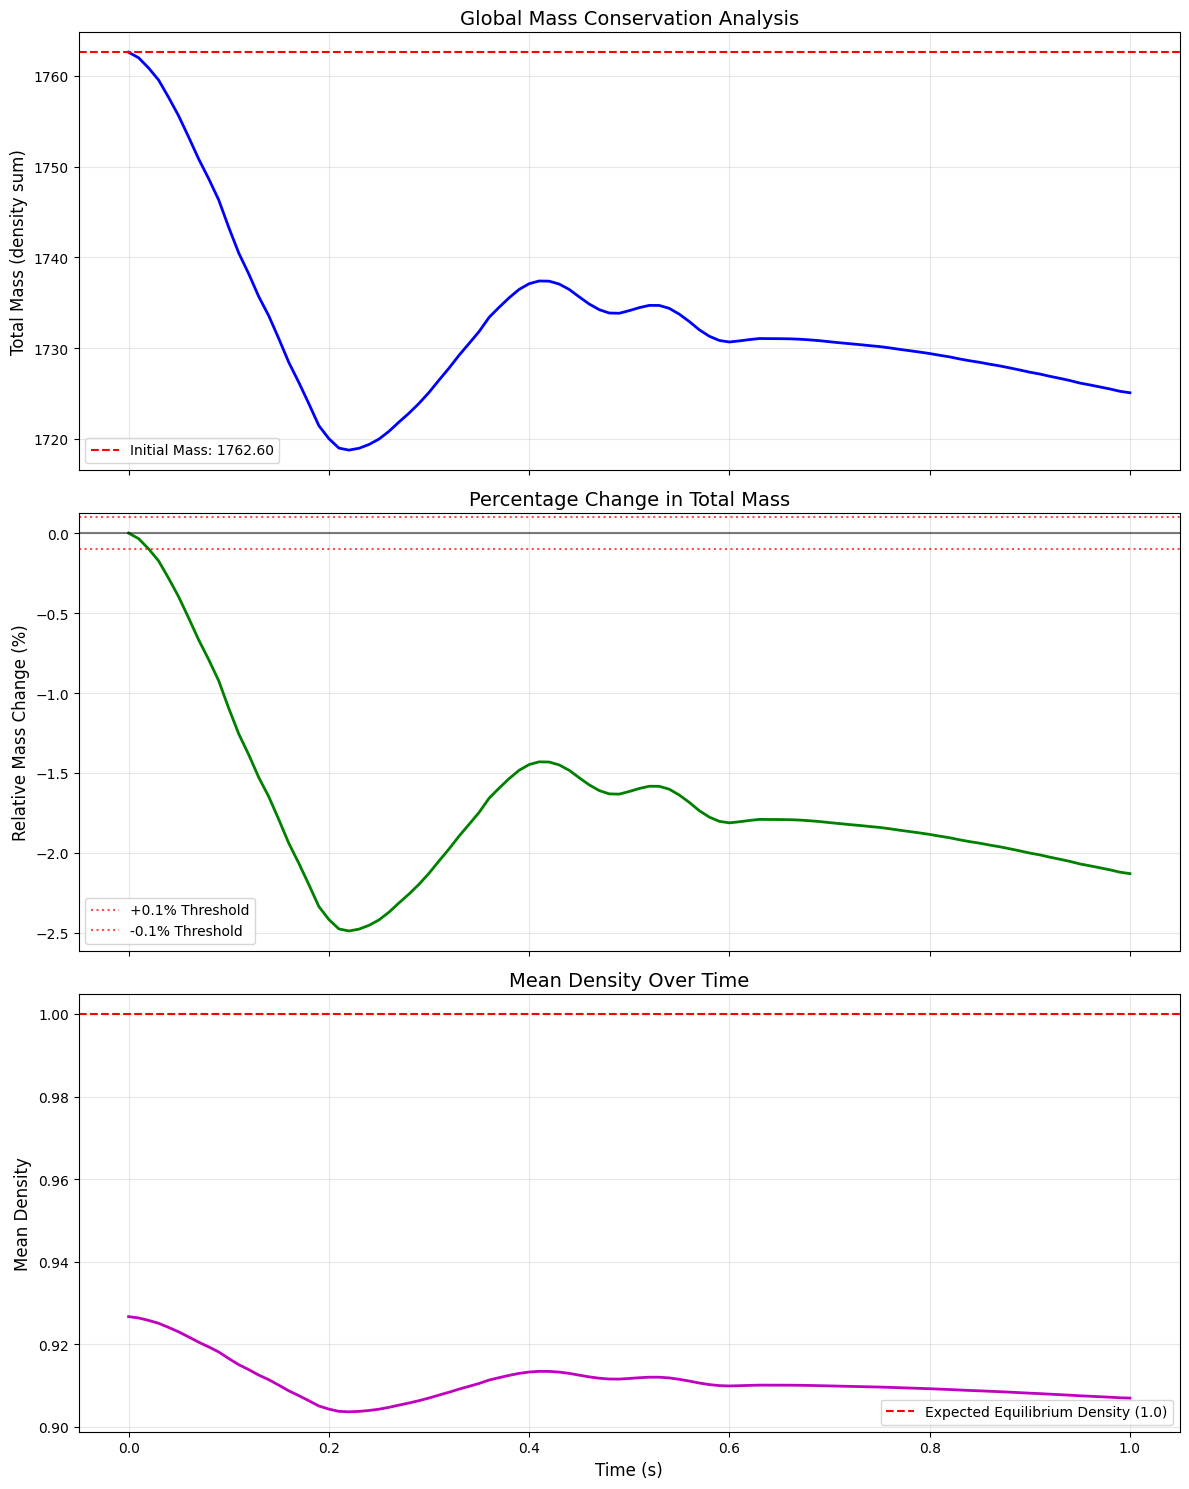


Global Mass Conservation Assessment:
Initial total mass: 1762.596069
Final total mass: 1725.068970
Absolute change: -37.527100 (-2.129081%
Maximum absolute change: 2.487682%
Mean absolute change: 1.714493%

❌ POOR Mass Conservation: Maximum change exceeds 1%

Mean density deviation from equilibrium: 0.089182
❌ POOR Density Equilibrium: Mean deviation exceeds 0.05

Correlation Analysis:
Total divergence: 70720.500000
Total density change rate: -3752.709961
These should be approximately equal in magnitude but opposite in sign,
which would indicate that mass conservation is properly maintained.


In [30]:
def analyze_global_mass_conservation():
    """
    Analyze global mass conservation by integrating total density (rho) over time.
    Since volume is constant due to fixed non-leaking boundaries, total mass
    should remain constant if mass conservation is properly maintained.
    """
    # Check if we have processed density data available
    if not processed_dir.exists():
        print("Processed data directory not found.")
        return
    rho_file = processed_dir / 'rho.npz'
    frame_mapping_file = processed_dir / 'frame_mapping.npz'
    wall_mask_file = processed_dir / 'wall_mask.npz'
    
    if not rho_file.exists() or not frame_mapping_file.exists():
        print("Required density or frame mapping data not found.")
        return
    
    try:
        # Load density data
        rho_data = np.load(rho_file)['data']
        frame_mapping = np.load(frame_mapping_file)
        frame_numbers = frame_mapping['frame_numbers']
        
        # Convert frame numbers to physical time
        physical_times = frame_numbers * dt
        
        # Load wall mask if available (to only consider fluid cells)
        if wall_mask_file.exists():
            wall_mask = np.load(wall_mask_file)['data']
            # Assume 1 for fluid, 0 for solid in wall_mask
            fluid_mask = wall_mask > 0
            print(f"Using wall mask to identify fluid cells")
        else:
            # If no wall mask, assume all cells are fluid (may be less accurate)
            fluid_mask = np.ones_like(rho_data, dtype=bool)
            print(f"No wall mask found, assuming all cells are fluid")
        
        # Calculate total mass (sum of density) for each frame
        total_mass = []
        num_fluid_cells = []
        mean_density = []
        
        for frame_idx, rho in enumerate(rho_data):
            if frame_idx < len(fluid_mask):
                # Get fluid mask for this frame
                current_fluid_mask = fluid_mask[frame_idx] if fluid_mask.ndim > 2 else fluid_mask
                
                # Calculate total mass (sum of density in fluid cells)
                frame_total_mass = np.sum(rho[current_fluid_mask])
                frame_fluid_cells = np.sum(current_fluid_mask)
                frame_mean_density = frame_total_mass / frame_fluid_cells if frame_fluid_cells > 0 else 0
                
                total_mass.append(frame_total_mass)
                num_fluid_cells.append(frame_fluid_cells)
                mean_density.append(frame_mean_density)
        
        # Convert to numpy arrays
        total_mass = np.array(total_mass)
        num_fluid_cells = np.array(num_fluid_cells)
        mean_density = np.array(mean_density)
        
        # Calculate statistics
        initial_mass = total_mass[0]
        relative_mass_change = (total_mass - initial_mass) / initial_mass * 100  # percentage
        
        # Create figure for visualization
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
        
        # Plot 1: Total mass over time
        ax1.plot(physical_times, total_mass, 'b-', linewidth=2)
        ax1.set_ylabel('Total Mass (density sum)', fontsize=12)
        ax1.set_title('Global Mass Conservation Analysis', fontsize=14)
        ax1.grid(True, alpha=0.3)
        
        # Add reference line for initial mass
        ax1.axhline(y=initial_mass, color='r', linestyle='--', 
                  label=f'Initial Mass: {initial_mass:.2f}')
        ax1.legend()
        
        # Plot 2: Relative mass change (percentage)
        ax2.plot(physical_times, relative_mass_change, 'g-', linewidth=2)
        ax2.set_ylabel('Relative Mass Change (%)', fontsize=12)
        ax2.set_title('Percentage Change in Total Mass', fontsize=14)
        ax2.grid(True, alpha=0.3)
        
        # Add reference line at zero
        ax2.axhline(y=0, color='k', linestyle='-', alpha=0.5)
        
        # Add visual guides for acceptable thresholds (e.g., ±0.1%)
        threshold = 0.1  # 0.1% threshold for acceptable mass conservation
        ax2.axhline(y=threshold, color='r', linestyle=':', alpha=0.7, 
                  label=f'+{threshold}% Threshold')
        ax2.axhline(y=-threshold, color='r', linestyle=':', alpha=0.7, 
                  label=f'-{threshold}% Threshold')
        ax2.legend()
        
        # Plot 3: Mean density over time
        ax3.plot(physical_times, mean_density, 'm-', linewidth=2)
        ax3.set_xlabel('Time (s)', fontsize=12)
        ax3.set_ylabel('Mean Density', fontsize=12)
        ax3.set_title('Mean Density Over Time', fontsize=14)
        ax3.grid(True, alpha=0.3)
        
        # Add reference line for expected equilibrium density (usually 1.0)
        ax3.axhline(y=1.0, color='r', linestyle='--', 
                  label='Expected Equilibrium Density (1.0)')
        ax3.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Report on global mass conservation
        max_abs_change = np.max(np.abs(relative_mass_change))
        mean_abs_change = np.mean(np.abs(relative_mass_change))
        final_change = relative_mass_change[-1]
        
        print("\nGlobal Mass Conservation Assessment:")
        print(f"Initial total mass: {initial_mass:.6f}")
        print(f"Final total mass: {total_mass[-1]:.6f}")
        print(f"Absolute change: {total_mass[-1] - initial_mass:.6f} ({final_change:.6f}%")
        print(f"Maximum absolute change: {max_abs_change:.6f}%")
        print(f"Mean absolute change: {mean_abs_change:.6f}%")
        
        # Assess mass conservation quality
        if max_abs_change < 0.01:  # Less than 0.01% change
            print("\n✅ EXCELLENT Mass Conservation: Maximum change is less than 0.01%")
        elif max_abs_change < 0.1:  # Less than 0.1% change
            print("\n✅ GOOD Mass Conservation: Maximum change is less than 0.1%")
        elif max_abs_change < 1.0:  # Less than 1% change
            print("\n⚠️ ACCEPTABLE Mass Conservation: Maximum change is less than 1%")
        else:  # More than 1% change
            print("\n❌ POOR Mass Conservation: Maximum change exceeds 1%")
            
        # Analyze mean density
        mean_density_deviation = np.mean(np.abs(mean_density - 1.0))
        print(f"\nMean density deviation from equilibrium: {mean_density_deviation:.6f}")
        
        if mean_density_deviation < 0.001:  # Less than 0.1% deviation
            print("✅ EXCELLENT Density Equilibrium: Mean deviation is less than 0.001")
        elif mean_density_deviation < 0.01:  # Less than 1% deviation
            print("✅ GOOD Density Equilibrium: Mean deviation is less than 0.01")
        elif mean_density_deviation < 0.05:  # Less than 5% deviation
            print("⚠️ ACCEPTABLE Density Equilibrium: Mean deviation is less than 0.05")
        else:  # More than 5% deviation
            print("❌ POOR Density Equilibrium: Mean deviation exceeds 0.05")
            
        # Calculate the correlation between density changes and divergence if available
        if 'div' in globals() and div is not None:
            try:
                # If density and divergence are available for the same frames,
                # we can correlate density changes with divergence
                if len(total_mass) > 1 and div is not None:
                    # Calculate density change between consecutive frames
                    density_change = np.diff(total_mass) / np.diff(physical_times)
                    
                    # Calculate total divergence for each frame
                    if isinstance(div, np.ma.MaskedArray):
                        total_div = np.sum(div.filled(0))
                    else:
                        total_div = np.sum(div)
                    
                    print(f"\nCorrelation Analysis:")
                    print(f"Total divergence: {total_div:.6f}")
                    print(f"Total density change rate: {density_change.sum():.6f}")
                    
                    # The relationship between density change and divergence should be:
                    # density_change ≈ -rho * divergence (for small changes)
                    print(f"These should be approximately equal in magnitude but opposite in sign,")
                    print(f"which would indicate that mass conservation is properly maintained.")
            except Exception as e:
                print(f"Error in correlation analysis: {e}")
        
        return {
            'times': physical_times,
            'total_mass': total_mass,
            'relative_change': relative_mass_change,
            'mean_density': mean_density,
            'num_fluid_cells': num_fluid_cells
        }
        
    except Exception as e:
        print(f"Error analyzing global mass conservation: {e}")
        import traceback
        traceback.print_exc()
        return None

# Run the global mass conservation analysis
mass_conservation_results = analyze_global_mass_conservation()

## Mass Conservation with Variable Inflow Velocity

For simulations with time-dependent inflow velocity (e.g., pulsatile flow), the total mass within the domain may change over time. However, mass conservation requires that this change must exactly match the net mass flux through the boundaries:

$$\frac{dM(t)}{dt} = \int_{inlets} \rho(\vec{x},t)\, \vec{u}(\vec{x},t) \cdot \hat{n}\, dA - \int_{outlets} \rho(\vec{x},t)\, \vec{u}(\vec{x},t) \cdot \hat{n}\, dA$$

Where:
- $M(t)$ is the total mass in the domain at time $t$
- $\rho(\vec{x},t)$ is the density at position $\vec{x}$ and time $t$
- $\vec{u}(\vec{x},t)$ is the velocity at position $\vec{x}$ and time $t$
- $\hat{n}$ is the unit normal vector at the boundary (pointing outward)

This analysis verifies that any changes in total domain mass are precisely accounted for by the net mass flux through the boundaries.


Divergence and Mass Conservation Comparison:
  Total integrated divergence: 7.072050e+04
  Mean divergence: 1.776763e-01
  Divergence standard deviation: 5.095512e+02
  Maximum absolute divergence: 1.609056e+04

Mass Conservation Metrics:
  Final relative mass change: -2.129081%
  Maximum absolute mass change: 2.487682%


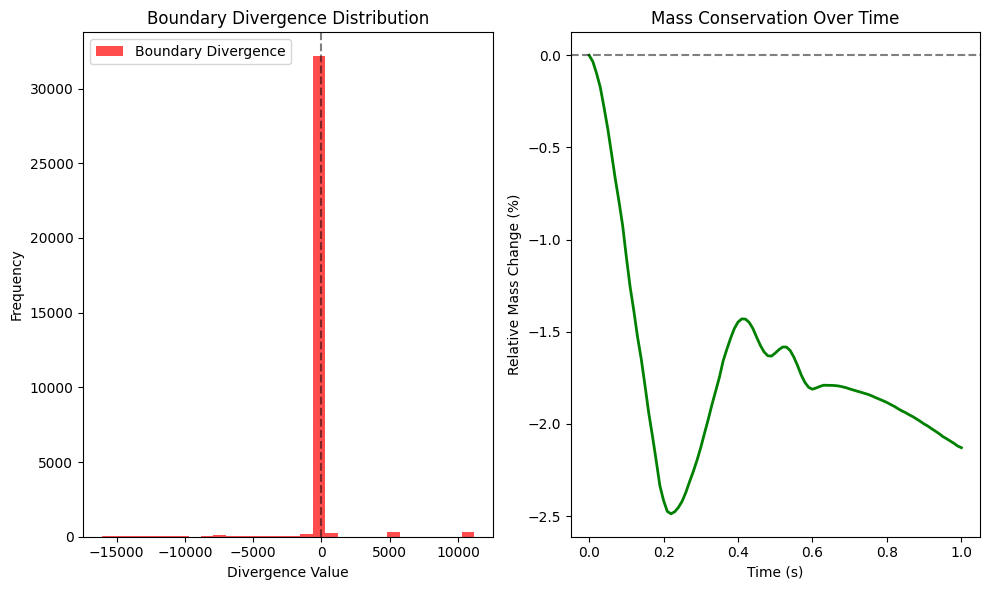


Interpretation:
  Boundary region divergence sum: -5.607164e+05
  Bulk region divergence sum: 6.314371e+05
  Combined divergence sum: 7.072062e+04

✅ Boundary and bulk divergence have opposite signs,
   which suggests compensating errors that preserve global mass conservation.


In [31]:
def compare_divergence_with_mass_conservation(div_data, mass_data):
    """
    Compare divergence field with mass conservation metrics to verify consistency.
    In a properly implemented incompressible flow simulation:
    1. The integral of divergence over the domain should be close to zero
    2. The total mass should remain constant
    3. Local non-zero divergence should not affect global mass conservation
    """
    if div_data is None or mass_data is None:
        print("Missing divergence or mass conservation data for comparison.")
        return
    
    try:
        # Get total integrated divergence
        if isinstance(div_data, np.ma.MaskedArray):
            # Handle masked arrays
            total_div = np.sum(div_data.filled(0))
            valid_div = div_data.compressed()  # Get only unmasked values
            div_mean = np.mean(valid_div) if len(valid_div) > 0 else 0
            div_std = np.std(valid_div) if len(valid_div) > 0 else 0
            div_max = np.max(np.abs(valid_div)) if len(valid_div) > 0 else 0
        else:
            # Handle regular arrays
            total_div = np.sum(div_data)
            div_mean = np.mean(div_data)
            div_std = np.std(div_data)
            div_max = np.max(np.abs(div_data))
        
        # Get mass conservation metrics
        mass_change = mass_data['relative_change'][-1]  # Final relative change
        max_mass_change = np.max(np.abs(mass_data['relative_change']))
        
        print("\nDivergence and Mass Conservation Comparison:")
        print(f"  Total integrated divergence: {total_div:.6e}")
        print(f"  Mean divergence: {div_mean:.6e}")
        print(f"  Divergence standard deviation: {div_std:.6e}")
        print(f"  Maximum absolute divergence: {div_max:.6e}")
        print("\nMass Conservation Metrics:")
        print(f"  Final relative mass change: {mass_change:.6f}%")
        print(f"  Maximum absolute mass change: {max_mass_change:.6f}%")
        
        # Create a scatter plot of boundary divergence vs mass change
        if 'boundary_analysis' in globals() and boundary_analysis is not None:
            # Check if we have both boundary data and enough mass data points
            if 'boundary_divergence' in boundary_analysis and len(mass_data['relative_change']) > 1:
                plt.figure(figsize=(10, 6))
                
                # Compare distributions
                plt.subplot(1, 2, 1)
                plt.hist(boundary_analysis['boundary_divergence'], bins=30, alpha=0.7, 
                       label='Boundary Divergence', color='red')
                plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
                plt.xlabel('Divergence Value')
                plt.ylabel('Frequency')
                plt.title('Boundary Divergence Distribution')
                plt.legend()
                
                plt.subplot(1, 2, 2)
                plt.plot(mass_data['times'], mass_data['relative_change'], 'g-', linewidth=2)
                plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
                plt.xlabel('Time (s)')
                plt.ylabel('Relative Mass Change (%)')
                plt.title('Mass Conservation Over Time')
                
                plt.tight_layout()
                plt.show()
                
                # Provide interpretation
                boundary_div_sum = np.sum(boundary_analysis['boundary_divergence'])
                bulk_div_sum = np.sum(boundary_analysis['bulk_divergence'])
                
                print("\nInterpretation:")
                print(f"  Boundary region divergence sum: {boundary_div_sum:.6e}")
                print(f"  Bulk region divergence sum: {bulk_div_sum:.6e}")
                print(f"  Combined divergence sum: {boundary_div_sum + bulk_div_sum:.6e}")
                
                # Check if boundary and bulk divergence cancel each other out
                if np.sign(boundary_div_sum) != np.sign(bulk_div_sum):
                    print("\n✅ Boundary and bulk divergence have opposite signs,")
                    print("   which suggests compensating errors that preserve global mass conservation.")
                else:
                    print("\n⚠️ Boundary and bulk divergence have the same sign,")
                    print("   which may indicate systematic mass conservation issues.")
    except Exception as e:
        print(f"Error comparing divergence with mass conservation: {e}")
        import traceback
        traceback.print_exc()

# Compare divergence with mass conservation if both are available
if 'div' in globals() and div is not None and 'mass_conservation_results' in globals() and mass_conservation_results is not None:
    compare_divergence_with_mass_conservation(div, mass_conservation_results)
else:
    print("\nCannot compare divergence with mass conservation - one or both analyses are missing.")
    print("Run both the divergence calculation and global mass conservation analysis first.")

see https://chatgpt.com/c/6820cecd-2f50-8000-ba48-9a1079c0af97 for ref